##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                  # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text Classification with Movie Reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/nnlm/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

### More models
[Here](https://tfhub.dev/s?module-type=text-embedding) you can find more expressive or performant models that you could use to generate the text embedding.

## Setup

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2023-09-04 11:29:19.999049: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-04 11:29:19.999099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-04 11:29:19.999134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Version:  2.14.0-rc1
Eager mode:  True
Hub version:  0.14.0
GPU is NOT AVAILABLE


2023-09-04 11:29:23.101036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's print first 10 examples.

In [6]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

Let's also print the first 10 labels.

In [7]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are two other models to test for the sake of this tutorial:
* [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of the smaller 50.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [8]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

Let's now build the full model:

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 50)                48190600  


 dense (Dense)               (None, 16)                816       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 48191433 (183.84 MB)


Trainable params: 48191433 (183.84 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


 1/30 [>.............................] - ETA: 31s - loss: 0.7046 - accuracy: 0.4961

 2/30 [=>............................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5020

 3/30 [==>...........................] - ETA: 16s - loss: 0.6991 - accuracy: 0.5091

 4/30 [===>..........................] - ETA: 15s - loss: 0.6954 - accuracy: 0.5200

 5/30 [====>.........................] - ETA: 15s - loss: 0.6944 - accuracy: 0.5238

 6/30 [=====>........................] - ETA: 14s - loss: 0.6927 - accuracy: 0.5345

 7/30 [======>.......................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5421

 8/30 [=======>......................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5520

 9/30 [========>.....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5560

10/30 [=========>....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5588

11/30 [==========>...................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5621

12/30 [===========>..................] - ETA: 10s - loss: 0.6862 - accuracy: 0.5618

13/30 [============>.................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5669

14/30 [=============>................] - ETA: 9s - loss: 0.6842 - accuracy: 0.5695 

15/30 [==============>...............] - ETA: 9s - loss: 0.6824 - accuracy: 0.5763

16/30 [===============>..............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5796

17/30 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.5839

18/30 [=================>............] - ETA: 7s - loss: 0.6791 - accuracy: 0.5885

19/30 [==================>...........] - ETA: 6s - loss: 0.6781 - accuracy: 0.5889

20/30 [===================>..........] - ETA: 6s - loss: 0.6767 - accuracy: 0.5945

21/30 [====================>.........] - ETA: 5s - loss: 0.6753 - accuracy: 0.5972

22/30 [=====================>........] - ETA: 4s - loss: 0.6741 - accuracy: 0.6009

23/30 [======================>.......] - ETA: 4s - loss: 0.6729 - accuracy: 0.6051

24/30 [=======================>......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6086

25/30 [========================>.....] - ETA: 3s - loss: 0.6701 - accuracy: 0.6117

26/30 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6146

27/30 [==========================>...] - ETA: 1s - loss: 0.6675 - accuracy: 0.6178

28/30 [===========================>..] - ETA: 1s - loss: 0.6659 - accuracy: 0.6219

29/30 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.6242

30/30 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.6249

30/30 [==============================] - 23s 743ms/step - loss: 0.6640 - accuracy: 0.6249 - val_loss: 0.6153 - val_accuracy: 0.7205


Epoch 2/40


 1/30 [>.............................] - ETA: 17s - loss: 0.6066 - accuracy: 0.7676

 2/30 [=>............................] - ETA: 17s - loss: 0.6037 - accuracy: 0.7617

 3/30 [==>...........................] - ETA: 16s - loss: 0.6007 - accuracy: 0.7611

 4/30 [===>..........................] - ETA: 15s - loss: 0.5978 - accuracy: 0.7651

 5/30 [====>.........................] - ETA: 15s - loss: 0.5972 - accuracy: 0.7613

 6/30 [=====>........................] - ETA: 14s - loss: 0.5960 - accuracy: 0.7588

 7/30 [======>.......................] - ETA: 13s - loss: 0.5952 - accuracy: 0.7567

 8/30 [=======>......................] - ETA: 13s - loss: 0.5914 - accuracy: 0.7620

 9/30 [========>.....................] - ETA: 12s - loss: 0.5895 - accuracy: 0.7630

10/30 [=========>....................] - ETA: 12s - loss: 0.5876 - accuracy: 0.7635

11/30 [==========>...................] - ETA: 11s - loss: 0.5859 - accuracy: 0.7624

12/30 [===========>..................] - ETA: 10s - loss: 0.5843 - accuracy: 0.7633

13/30 [============>.................] - ETA: 10s - loss: 0.5817 - accuracy: 0.7647

14/30 [=============>................] - ETA: 9s - loss: 0.5795 - accuracy: 0.7660 

15/30 [==============>...............] - ETA: 9s - loss: 0.5771 - accuracy: 0.7681

16/30 [===============>..............] - ETA: 8s - loss: 0.5748 - accuracy: 0.7701

17/30 [================>.............] - ETA: 7s - loss: 0.5723 - accuracy: 0.7710

18/30 [=================>............] - ETA: 7s - loss: 0.5717 - accuracy: 0.7704

19/30 [==================>...........] - ETA: 6s - loss: 0.5701 - accuracy: 0.7708

20/30 [===================>..........] - ETA: 6s - loss: 0.5676 - accuracy: 0.7731

21/30 [====================>.........] - ETA: 5s - loss: 0.5666 - accuracy: 0.7732

22/30 [=====================>........] - ETA: 4s - loss: 0.5650 - accuracy: 0.7743

23/30 [======================>.......] - ETA: 4s - loss: 0.5626 - accuracy: 0.7757

24/30 [=======================>......] - ETA: 3s - loss: 0.5602 - accuracy: 0.7773

25/30 [========================>.....] - ETA: 3s - loss: 0.5589 - accuracy: 0.7767

26/30 [=========================>....] - ETA: 2s - loss: 0.5570 - accuracy: 0.7774

27/30 [==========================>...] - ETA: 1s - loss: 0.5553 - accuracy: 0.7778

28/30 [===========================>..] - ETA: 1s - loss: 0.5536 - accuracy: 0.7784

29/30 [============================>.] - ETA: 0s - loss: 0.5524 - accuracy: 0.7789

30/30 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7793

30/30 [==============================] - 22s 746ms/step - loss: 0.5516 - accuracy: 0.7793 - val_loss: 0.5068 - val_accuracy: 0.7946


Epoch 3/40


 1/30 [>.............................] - ETA: 17s - loss: 0.4602 - accuracy: 0.8574

 2/30 [=>............................] - ETA: 17s - loss: 0.4663 - accuracy: 0.8320

 3/30 [==>...........................] - ETA: 16s - loss: 0.4673 - accuracy: 0.8346

 4/30 [===>..........................] - ETA: 16s - loss: 0.4668 - accuracy: 0.8359

 5/30 [====>.........................] - ETA: 15s - loss: 0.4654 - accuracy: 0.8348

 6/30 [=====>........................] - ETA: 14s - loss: 0.4657 - accuracy: 0.8330

 7/30 [======>.......................] - ETA: 14s - loss: 0.4628 - accuracy: 0.8340

 8/30 [=======>......................] - ETA: 13s - loss: 0.4620 - accuracy: 0.8330

 9/30 [========>.....................] - ETA: 12s - loss: 0.4586 - accuracy: 0.8340

10/30 [=========>....................] - ETA: 12s - loss: 0.4565 - accuracy: 0.8354

11/30 [==========>...................] - ETA: 11s - loss: 0.4565 - accuracy: 0.8347

12/30 [===========>..................] - ETA: 10s - loss: 0.4543 - accuracy: 0.8358

13/30 [============>.................] - ETA: 10s - loss: 0.4516 - accuracy: 0.8388

14/30 [=============>................] - ETA: 9s - loss: 0.4514 - accuracy: 0.8372 

15/30 [==============>...............] - ETA: 9s - loss: 0.4496 - accuracy: 0.8380

16/30 [===============>..............] - ETA: 8s - loss: 0.4472 - accuracy: 0.8396

17/30 [================>.............] - ETA: 7s - loss: 0.4462 - accuracy: 0.8406

18/30 [=================>............] - ETA: 7s - loss: 0.4440 - accuracy: 0.8418

19/30 [==================>...........] - ETA: 6s - loss: 0.4418 - accuracy: 0.8436

20/30 [===================>..........] - ETA: 6s - loss: 0.4393 - accuracy: 0.8454

21/30 [====================>.........] - ETA: 5s - loss: 0.4366 - accuracy: 0.8464

22/30 [=====================>........] - ETA: 4s - loss: 0.4351 - accuracy: 0.8465

23/30 [======================>.......] - ETA: 4s - loss: 0.4329 - accuracy: 0.8468

24/30 [=======================>......] - ETA: 3s - loss: 0.4309 - accuracy: 0.8475

25/30 [========================>.....] - ETA: 3s - loss: 0.4295 - accuracy: 0.8487

26/30 [=========================>....] - ETA: 2s - loss: 0.4278 - accuracy: 0.8492

27/30 [==========================>...] - ETA: 1s - loss: 0.4256 - accuracy: 0.8500

28/30 [===========================>..] - ETA: 1s - loss: 0.4241 - accuracy: 0.8504

29/30 [============================>.] - ETA: 0s - loss: 0.4223 - accuracy: 0.8510

30/30 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8515

30/30 [==============================] - 22s 738ms/step - loss: 0.4214 - accuracy: 0.8515 - val_loss: 0.4082 - val_accuracy: 0.8419


Epoch 4/40


 1/30 [>.............................] - ETA: 17s - loss: 0.3372 - accuracy: 0.8848

 2/30 [=>............................] - ETA: 17s - loss: 0.3302 - accuracy: 0.9004

 3/30 [==>...........................] - ETA: 16s - loss: 0.3268 - accuracy: 0.9069

 4/30 [===>..........................] - ETA: 15s - loss: 0.3254 - accuracy: 0.9043

 5/30 [====>.........................] - ETA: 15s - loss: 0.3304 - accuracy: 0.9008

 6/30 [=====>........................] - ETA: 14s - loss: 0.3301 - accuracy: 0.9007

 7/30 [======>.......................] - ETA: 14s - loss: 0.3307 - accuracy: 0.8990

 8/30 [=======>......................] - ETA: 13s - loss: 0.3296 - accuracy: 0.8987

 9/30 [========>.....................] - ETA: 12s - loss: 0.3300 - accuracy: 0.8971

10/30 [=========>....................] - ETA: 12s - loss: 0.3271 - accuracy: 0.8984

11/30 [==========>...................] - ETA: 11s - loss: 0.3260 - accuracy: 0.8988

12/30 [===========>..................] - ETA: 10s - loss: 0.3255 - accuracy: 0.8997

13/30 [============>.................] - ETA: 10s - loss: 0.3255 - accuracy: 0.8990

14/30 [=============>................] - ETA: 9s - loss: 0.3255 - accuracy: 0.8987 

15/30 [==============>...............] - ETA: 9s - loss: 0.3253 - accuracy: 0.8975

16/30 [===============>..............] - ETA: 8s - loss: 0.3242 - accuracy: 0.8964

17/30 [================>.............] - ETA: 7s - loss: 0.3231 - accuracy: 0.8966

18/30 [=================>............] - ETA: 7s - loss: 0.3225 - accuracy: 0.8961

19/30 [==================>...........] - ETA: 6s - loss: 0.3228 - accuracy: 0.8956

20/30 [===================>..........] - ETA: 6s - loss: 0.3215 - accuracy: 0.8960

21/30 [====================>.........] - ETA: 5s - loss: 0.3190 - accuracy: 0.8969

22/30 [=====================>........] - ETA: 4s - loss: 0.3175 - accuracy: 0.8968

23/30 [======================>.......] - ETA: 4s - loss: 0.3160 - accuracy: 0.8978

24/30 [=======================>......] - ETA: 3s - loss: 0.3152 - accuracy: 0.8976

25/30 [========================>.....] - ETA: 3s - loss: 0.3139 - accuracy: 0.8982

26/30 [=========================>....] - ETA: 2s - loss: 0.3134 - accuracy: 0.8977

27/30 [==========================>...] - ETA: 1s - loss: 0.3128 - accuracy: 0.8973

28/30 [===========================>..] - ETA: 1s - loss: 0.3118 - accuracy: 0.8977

29/30 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8982

30/30 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8981

30/30 [==============================] - 22s 739ms/step - loss: 0.3099 - accuracy: 0.8981 - val_loss: 0.3496 - val_accuracy: 0.8581


Epoch 5/40


 1/30 [>.............................] - ETA: 17s - loss: 0.2754 - accuracy: 0.9082

 2/30 [=>............................] - ETA: 17s - loss: 0.2694 - accuracy: 0.9092

 3/30 [==>...........................] - ETA: 16s - loss: 0.2754 - accuracy: 0.9043

 4/30 [===>..........................] - ETA: 15s - loss: 0.2688 - accuracy: 0.9102

 5/30 [====>.........................] - ETA: 15s - loss: 0.2642 - accuracy: 0.9105

 6/30 [=====>........................] - ETA: 14s - loss: 0.2594 - accuracy: 0.9154

 7/30 [======>.......................] - ETA: 13s - loss: 0.2553 - accuracy: 0.9157

 8/30 [=======>......................] - ETA: 13s - loss: 0.2529 - accuracy: 0.9167

 9/30 [========>.....................] - ETA: 12s - loss: 0.2507 - accuracy: 0.9191

10/30 [=========>....................] - ETA: 12s - loss: 0.2484 - accuracy: 0.9209

11/30 [==========>...................] - ETA: 11s - loss: 0.2466 - accuracy: 0.9222

12/30 [===========>..................] - ETA: 10s - loss: 0.2467 - accuracy: 0.9220

13/30 [============>.................] - ETA: 10s - loss: 0.2449 - accuracy: 0.9219

14/30 [=============>................] - ETA: 9s - loss: 0.2446 - accuracy: 0.9215 

15/30 [==============>...............] - ETA: 9s - loss: 0.2460 - accuracy: 0.9203

16/30 [===============>..............] - ETA: 8s - loss: 0.2463 - accuracy: 0.9196

17/30 [================>.............] - ETA: 7s - loss: 0.2439 - accuracy: 0.9202

18/30 [=================>............] - ETA: 7s - loss: 0.2434 - accuracy: 0.9204

19/30 [==================>...........] - ETA: 6s - loss: 0.2430 - accuracy: 0.9199

20/30 [===================>..........] - ETA: 6s - loss: 0.2409 - accuracy: 0.9213

21/30 [====================>.........] - ETA: 5s - loss: 0.2388 - accuracy: 0.9223

22/30 [=====================>........] - ETA: 4s - loss: 0.2367 - accuracy: 0.9237

23/30 [======================>.......] - ETA: 4s - loss: 0.2356 - accuracy: 0.9241

24/30 [=======================>......] - ETA: 3s - loss: 0.2362 - accuracy: 0.9237

25/30 [========================>.....] - ETA: 3s - loss: 0.2352 - accuracy: 0.9244

26/30 [=========================>....] - ETA: 2s - loss: 0.2346 - accuracy: 0.9244

27/30 [==========================>...] - ETA: 1s - loss: 0.2335 - accuracy: 0.9249

28/30 [===========================>..] - ETA: 1s - loss: 0.2325 - accuracy: 0.9251

29/30 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9258

30/30 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9257

30/30 [==============================] - 22s 734ms/step - loss: 0.2304 - accuracy: 0.9257 - val_loss: 0.3167 - val_accuracy: 0.8677


Epoch 6/40


 1/30 [>.............................] - ETA: 17s - loss: 0.1667 - accuracy: 0.9668

 2/30 [=>............................] - ETA: 17s - loss: 0.1758 - accuracy: 0.9561

 3/30 [==>...........................] - ETA: 16s - loss: 0.1825 - accuracy: 0.9505

 4/30 [===>..........................] - ETA: 16s - loss: 0.1829 - accuracy: 0.9502

 5/30 [====>.........................] - ETA: 15s - loss: 0.1842 - accuracy: 0.9477

 6/30 [=====>........................] - ETA: 14s - loss: 0.1830 - accuracy: 0.9495

 7/30 [======>.......................] - ETA: 14s - loss: 0.1821 - accuracy: 0.9492

 8/30 [=======>......................] - ETA: 13s - loss: 0.1794 - accuracy: 0.9480

 9/30 [========>.....................] - ETA: 12s - loss: 0.1797 - accuracy: 0.9479

10/30 [=========>....................] - ETA: 12s - loss: 0.1793 - accuracy: 0.9482

11/30 [==========>...................] - ETA: 11s - loss: 0.1779 - accuracy: 0.9485

12/30 [===========>..................] - ETA: 11s - loss: 0.1776 - accuracy: 0.9479

13/30 [============>.................] - ETA: 10s - loss: 0.1763 - accuracy: 0.9476

14/30 [=============>................] - ETA: 9s - loss: 0.1767 - accuracy: 0.9470 

15/30 [==============>...............] - ETA: 9s - loss: 0.1760 - accuracy: 0.9470

16/30 [===============>..............] - ETA: 8s - loss: 0.1753 - accuracy: 0.9476

17/30 [================>.............] - ETA: 8s - loss: 0.1768 - accuracy: 0.9470

18/30 [=================>............] - ETA: 7s - loss: 0.1752 - accuracy: 0.9476

19/30 [==================>...........] - ETA: 6s - loss: 0.1742 - accuracy: 0.9482

20/30 [===================>..........] - ETA: 6s - loss: 0.1737 - accuracy: 0.9488

21/30 [====================>.........] - ETA: 5s - loss: 0.1736 - accuracy: 0.9490

22/30 [=====================>........] - ETA: 4s - loss: 0.1733 - accuracy: 0.9490

23/30 [======================>.......] - ETA: 4s - loss: 0.1728 - accuracy: 0.9494

24/30 [=======================>......] - ETA: 3s - loss: 0.1730 - accuracy: 0.9491

25/30 [========================>.....] - ETA: 3s - loss: 0.1736 - accuracy: 0.9484

26/30 [=========================>....] - ETA: 2s - loss: 0.1725 - accuracy: 0.9489

27/30 [==========================>...] - ETA: 1s - loss: 0.1726 - accuracy: 0.9489

28/30 [===========================>..] - ETA: 1s - loss: 0.1730 - accuracy: 0.9487

29/30 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9487

30/30 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9489

30/30 [==============================] - 22s 743ms/step - loss: 0.1721 - accuracy: 0.9489 - val_loss: 0.3019 - val_accuracy: 0.8757


Epoch 7/40


 1/30 [>.............................] - ETA: 17s - loss: 0.1296 - accuracy: 0.9648

 2/30 [=>............................] - ETA: 16s - loss: 0.1366 - accuracy: 0.9609

 3/30 [==>...........................] - ETA: 16s - loss: 0.1356 - accuracy: 0.9629

 4/30 [===>..........................] - ETA: 15s - loss: 0.1327 - accuracy: 0.9653

 5/30 [====>.........................] - ETA: 15s - loss: 0.1320 - accuracy: 0.9641

 6/30 [=====>........................] - ETA: 14s - loss: 0.1298 - accuracy: 0.9652

 7/30 [======>.......................] - ETA: 13s - loss: 0.1295 - accuracy: 0.9657

 8/30 [=======>......................] - ETA: 13s - loss: 0.1296 - accuracy: 0.9651

 9/30 [========>.....................] - ETA: 12s - loss: 0.1314 - accuracy: 0.9633

10/30 [=========>....................] - ETA: 12s - loss: 0.1303 - accuracy: 0.9650

11/30 [==========>...................] - ETA: 11s - loss: 0.1305 - accuracy: 0.9647

12/30 [===========>..................] - ETA: 10s - loss: 0.1322 - accuracy: 0.9637

13/30 [============>.................] - ETA: 10s - loss: 0.1315 - accuracy: 0.9639

14/30 [=============>................] - ETA: 9s - loss: 0.1311 - accuracy: 0.9643 

15/30 [==============>...............] - ETA: 9s - loss: 0.1303 - accuracy: 0.9648

16/30 [===============>..............] - ETA: 8s - loss: 0.1294 - accuracy: 0.9651

17/30 [================>.............] - ETA: 7s - loss: 0.1281 - accuracy: 0.9661

18/30 [=================>............] - ETA: 7s - loss: 0.1281 - accuracy: 0.9665

19/30 [==================>...........] - ETA: 6s - loss: 0.1269 - accuracy: 0.9667

20/30 [===================>..........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9660

21/30 [====================>.........] - ETA: 5s - loss: 0.1291 - accuracy: 0.9658

22/30 [=====================>........] - ETA: 4s - loss: 0.1293 - accuracy: 0.9657

23/30 [======================>.......] - ETA: 4s - loss: 0.1280 - accuracy: 0.9663

24/30 [=======================>......] - ETA: 3s - loss: 0.1281 - accuracy: 0.9661

25/30 [========================>.....] - ETA: 3s - loss: 0.1280 - accuracy: 0.9660

26/30 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9666

27/30 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9664

28/30 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9664

29/30 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9664

30/30 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.9665

30/30 [==============================] - 22s 741ms/step - loss: 0.1265 - accuracy: 0.9665 - val_loss: 0.3004 - val_accuracy: 0.8763


Epoch 8/40


 1/30 [>.............................] - ETA: 17s - loss: 0.1110 - accuracy: 0.9746

 2/30 [=>............................] - ETA: 17s - loss: 0.0983 - accuracy: 0.9766

 3/30 [==>...........................] - ETA: 16s - loss: 0.0995 - accuracy: 0.9759

 4/30 [===>..........................] - ETA: 15s - loss: 0.0979 - accuracy: 0.9771

 5/30 [====>.........................] - ETA: 15s - loss: 0.0971 - accuracy: 0.9773

 6/30 [=====>........................] - ETA: 14s - loss: 0.0961 - accuracy: 0.9782

 7/30 [======>.......................] - ETA: 13s - loss: 0.0974 - accuracy: 0.9782

 8/30 [=======>......................] - ETA: 13s - loss: 0.0991 - accuracy: 0.9773

 9/30 [========>.....................] - ETA: 12s - loss: 0.0965 - accuracy: 0.9792

10/30 [=========>....................] - ETA: 12s - loss: 0.0963 - accuracy: 0.9795

11/30 [==========>...................] - ETA: 11s - loss: 0.0939 - accuracy: 0.9805

12/30 [===========>..................] - ETA: 11s - loss: 0.0932 - accuracy: 0.9805

13/30 [============>.................] - ETA: 10s - loss: 0.0925 - accuracy: 0.9802

14/30 [=============>................] - ETA: 9s - loss: 0.0918 - accuracy: 0.9805 

15/30 [==============>...............] - ETA: 9s - loss: 0.0924 - accuracy: 0.9801

16/30 [===============>..............] - ETA: 8s - loss: 0.0929 - accuracy: 0.9800

17/30 [================>.............] - ETA: 7s - loss: 0.0940 - accuracy: 0.9797

18/30 [=================>............] - ETA: 7s - loss: 0.0937 - accuracy: 0.9798

19/30 [==================>...........] - ETA: 6s - loss: 0.0944 - accuracy: 0.9797

20/30 [===================>..........] - ETA: 6s - loss: 0.0942 - accuracy: 0.9799

21/30 [====================>.........] - ETA: 5s - loss: 0.0939 - accuracy: 0.9801

22/30 [=====================>........] - ETA: 4s - loss: 0.0936 - accuracy: 0.9802

23/30 [======================>.......] - ETA: 4s - loss: 0.0930 - accuracy: 0.9804

24/30 [=======================>......] - ETA: 3s - loss: 0.0934 - accuracy: 0.9802

25/30 [========================>.....] - ETA: 3s - loss: 0.0934 - accuracy: 0.9799

26/30 [=========================>....] - ETA: 2s - loss: 0.0933 - accuracy: 0.9796

27/30 [==========================>...] - ETA: 1s - loss: 0.0936 - accuracy: 0.9791

28/30 [===========================>..] - ETA: 1s - loss: 0.0935 - accuracy: 0.9791

29/30 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9790

30/30 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9790

30/30 [==============================] - 22s 739ms/step - loss: 0.0931 - accuracy: 0.9790 - val_loss: 0.3033 - val_accuracy: 0.8765


Epoch 9/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0639 - accuracy: 0.9902

 2/30 [=>............................] - ETA: 16s - loss: 0.0637 - accuracy: 0.9873

 3/30 [==>...........................] - ETA: 16s - loss: 0.0666 - accuracy: 0.9870

 4/30 [===>..........................] - ETA: 15s - loss: 0.0708 - accuracy: 0.9849

 5/30 [====>.........................] - ETA: 15s - loss: 0.0689 - accuracy: 0.9867

 6/30 [=====>........................] - ETA: 14s - loss: 0.0684 - accuracy: 0.9870

 7/30 [======>.......................] - ETA: 14s - loss: 0.0696 - accuracy: 0.9866

 8/30 [=======>......................] - ETA: 13s - loss: 0.0710 - accuracy: 0.9866

 9/30 [========>.....................] - ETA: 12s - loss: 0.0704 - accuracy: 0.9861

10/30 [=========>....................] - ETA: 12s - loss: 0.0688 - accuracy: 0.9869

11/30 [==========>...................] - ETA: 11s - loss: 0.0683 - accuracy: 0.9874

12/30 [===========>..................] - ETA: 10s - loss: 0.0687 - accuracy: 0.9876

13/30 [============>.................] - ETA: 10s - loss: 0.0694 - accuracy: 0.9872

14/30 [=============>................] - ETA: 9s - loss: 0.0694 - accuracy: 0.9874 

15/30 [==============>...............] - ETA: 9s - loss: 0.0680 - accuracy: 0.9878

16/30 [===============>..............] - ETA: 8s - loss: 0.0679 - accuracy: 0.9877

17/30 [================>.............] - ETA: 7s - loss: 0.0673 - accuracy: 0.9879

18/30 [=================>............] - ETA: 7s - loss: 0.0671 - accuracy: 0.9880

19/30 [==================>...........] - ETA: 6s - loss: 0.0676 - accuracy: 0.9881

20/30 [===================>..........] - ETA: 6s - loss: 0.0672 - accuracy: 0.9879

21/30 [====================>.........] - ETA: 5s - loss: 0.0669 - accuracy: 0.9881

22/30 [=====================>........] - ETA: 4s - loss: 0.0663 - accuracy: 0.9884

23/30 [======================>.......] - ETA: 4s - loss: 0.0662 - accuracy: 0.9884

24/30 [=======================>......] - ETA: 3s - loss: 0.0665 - accuracy: 0.9881

25/30 [========================>.....] - ETA: 3s - loss: 0.0663 - accuracy: 0.9879

26/30 [=========================>....] - ETA: 2s - loss: 0.0660 - accuracy: 0.9879

27/30 [==========================>...] - ETA: 1s - loss: 0.0662 - accuracy: 0.9879

28/30 [===========================>..] - ETA: 1s - loss: 0.0663 - accuracy: 0.9877

29/30 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9875

30/30 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9874

30/30 [==============================] - 22s 739ms/step - loss: 0.0666 - accuracy: 0.9874 - val_loss: 0.3090 - val_accuracy: 0.8767


Epoch 10/40


 1/30 [>.............................] - ETA: 18s - loss: 0.0496 - accuracy: 0.9961

 2/30 [=>............................] - ETA: 17s - loss: 0.0463 - accuracy: 0.9961

 3/30 [==>...........................] - ETA: 16s - loss: 0.0457 - accuracy: 0.9948

 4/30 [===>..........................] - ETA: 15s - loss: 0.0495 - accuracy: 0.9932

 5/30 [====>.........................] - ETA: 15s - loss: 0.0496 - accuracy: 0.9937

 6/30 [=====>........................] - ETA: 14s - loss: 0.0499 - accuracy: 0.9935

 7/30 [======>.......................] - ETA: 13s - loss: 0.0479 - accuracy: 0.9941

 8/30 [=======>......................] - ETA: 13s - loss: 0.0476 - accuracy: 0.9949

 9/30 [========>.....................] - ETA: 12s - loss: 0.0473 - accuracy: 0.9952

10/30 [=========>....................] - ETA: 12s - loss: 0.0471 - accuracy: 0.9951

11/30 [==========>...................] - ETA: 11s - loss: 0.0481 - accuracy: 0.9943

12/30 [===========>..................] - ETA: 10s - loss: 0.0477 - accuracy: 0.9945

13/30 [============>.................] - ETA: 10s - loss: 0.0475 - accuracy: 0.9946

14/30 [=============>................] - ETA: 9s - loss: 0.0471 - accuracy: 0.9944 

15/30 [==============>...............] - ETA: 9s - loss: 0.0468 - accuracy: 0.9945

16/30 [===============>..............] - ETA: 8s - loss: 0.0467 - accuracy: 0.9946

17/30 [================>.............] - ETA: 7s - loss: 0.0467 - accuracy: 0.9943

18/30 [=================>............] - ETA: 7s - loss: 0.0473 - accuracy: 0.9942

19/30 [==================>...........] - ETA: 6s - loss: 0.0470 - accuracy: 0.9942

20/30 [===================>..........] - ETA: 6s - loss: 0.0469 - accuracy: 0.9943

21/30 [====================>.........] - ETA: 5s - loss: 0.0472 - accuracy: 0.9941

22/30 [=====================>........] - ETA: 4s - loss: 0.0469 - accuracy: 0.9941

23/30 [======================>.......] - ETA: 4s - loss: 0.0464 - accuracy: 0.9943

24/30 [=======================>......] - ETA: 3s - loss: 0.0463 - accuracy: 0.9942

25/30 [========================>.....] - ETA: 3s - loss: 0.0469 - accuracy: 0.9942

26/30 [=========================>....] - ETA: 2s - loss: 0.0468 - accuracy: 0.9943

27/30 [==========================>...] - ETA: 1s - loss: 0.0467 - accuracy: 0.9943

28/30 [===========================>..] - ETA: 1s - loss: 0.0465 - accuracy: 0.9943

29/30 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9945

30/30 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9946

30/30 [==============================] - 22s 738ms/step - loss: 0.0461 - accuracy: 0.9946 - val_loss: 0.3234 - val_accuracy: 0.8751


Epoch 11/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0280 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9961

 3/30 [==>...........................] - ETA: 16s - loss: 0.0352 - accuracy: 0.9967

 4/30 [===>..........................] - ETA: 15s - loss: 0.0338 - accuracy: 0.9971

 5/30 [====>.........................] - ETA: 15s - loss: 0.0345 - accuracy: 0.9965

 6/30 [=====>........................] - ETA: 14s - loss: 0.0341 - accuracy: 0.9964

 7/30 [======>.......................] - ETA: 13s - loss: 0.0346 - accuracy: 0.9964

 8/30 [=======>......................] - ETA: 13s - loss: 0.0337 - accuracy: 0.9966

 9/30 [========>.....................] - ETA: 12s - loss: 0.0337 - accuracy: 0.9965

10/30 [=========>....................] - ETA: 12s - loss: 0.0331 - accuracy: 0.9969

11/30 [==========>...................] - ETA: 11s - loss: 0.0332 - accuracy: 0.9968

12/30 [===========>..................] - ETA: 10s - loss: 0.0330 - accuracy: 0.9969

13/30 [============>.................] - ETA: 10s - loss: 0.0346 - accuracy: 0.9965

14/30 [=============>................] - ETA: 9s - loss: 0.0341 - accuracy: 0.9968 

15/30 [==============>...............] - ETA: 9s - loss: 0.0346 - accuracy: 0.9965

16/30 [===============>..............] - ETA: 8s - loss: 0.0340 - accuracy: 0.9966

17/30 [================>.............] - ETA: 7s - loss: 0.0339 - accuracy: 0.9967

18/30 [=================>............] - ETA: 7s - loss: 0.0335 - accuracy: 0.9969

19/30 [==================>...........] - ETA: 6s - loss: 0.0334 - accuracy: 0.9968

20/30 [===================>..........] - ETA: 6s - loss: 0.0331 - accuracy: 0.9970

21/30 [====================>.........] - ETA: 5s - loss: 0.0331 - accuracy: 0.9969

22/30 [=====================>........] - ETA: 4s - loss: 0.0329 - accuracy: 0.9970

23/30 [======================>.......] - ETA: 4s - loss: 0.0326 - accuracy: 0.9971

24/30 [=======================>......] - ETA: 3s - loss: 0.0322 - accuracy: 0.9971

25/30 [========================>.....] - ETA: 3s - loss: 0.0320 - accuracy: 0.9972

26/30 [=========================>....] - ETA: 2s - loss: 0.0319 - accuracy: 0.9972

27/30 [==========================>...] - ETA: 1s - loss: 0.0316 - accuracy: 0.9973

28/30 [===========================>..] - ETA: 1s - loss: 0.0315 - accuracy: 0.9973

29/30 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9973

30/30 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9973

30/30 [==============================] - 22s 741ms/step - loss: 0.0314 - accuracy: 0.9973 - val_loss: 0.3412 - val_accuracy: 0.8746


Epoch 12/40


 1/30 [>.............................] - ETA: 18s - loss: 0.0223 - accuracy: 0.9980

 2/30 [=>............................] - ETA: 17s - loss: 0.0225 - accuracy: 0.9990

 3/30 [==>...........................] - ETA: 16s - loss: 0.0211 - accuracy: 0.9993

 4/30 [===>..........................] - ETA: 16s - loss: 0.0210 - accuracy: 0.9995

 5/30 [====>.........................] - ETA: 15s - loss: 0.0226 - accuracy: 0.9984

 6/30 [=====>........................] - ETA: 14s - loss: 0.0217 - accuracy: 0.9987

 7/30 [======>.......................] - ETA: 14s - loss: 0.0212 - accuracy: 0.9989

 8/30 [=======>......................] - ETA: 13s - loss: 0.0212 - accuracy: 0.9990

 9/30 [========>.....................] - ETA: 12s - loss: 0.0213 - accuracy: 0.9991

10/30 [=========>....................] - ETA: 12s - loss: 0.0210 - accuracy: 0.9992

11/30 [==========>...................] - ETA: 11s - loss: 0.0208 - accuracy: 0.9993

12/30 [===========>..................] - ETA: 11s - loss: 0.0209 - accuracy: 0.9993

13/30 [============>.................] - ETA: 10s - loss: 0.0207 - accuracy: 0.9992

14/30 [=============>................] - ETA: 9s - loss: 0.0209 - accuracy: 0.9992 

15/30 [==============>...............] - ETA: 9s - loss: 0.0213 - accuracy: 0.9990

16/30 [===============>..............] - ETA: 8s - loss: 0.0211 - accuracy: 0.9990

17/30 [================>.............] - ETA: 8s - loss: 0.0212 - accuracy: 0.9990

18/30 [=================>............] - ETA: 7s - loss: 0.0209 - accuracy: 0.9990

19/30 [==================>...........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9990

20/30 [===================>..........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9990

21/30 [====================>.........] - ETA: 5s - loss: 0.0214 - accuracy: 0.9990

22/30 [=====================>........] - ETA: 4s - loss: 0.0213 - accuracy: 0.9990

23/30 [======================>.......] - ETA: 4s - loss: 0.0214 - accuracy: 0.9990

24/30 [=======================>......] - ETA: 3s - loss: 0.0213 - accuracy: 0.9989

25/30 [========================>.....] - ETA: 3s - loss: 0.0213 - accuracy: 0.9989

26/30 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9989

27/30 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9990

28/30 [===========================>..] - ETA: 1s - loss: 0.0213 - accuracy: 0.9990

29/30 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9989

30/30 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9989

30/30 [==============================] - 22s 741ms/step - loss: 0.0211 - accuracy: 0.9989 - val_loss: 0.3582 - val_accuracy: 0.8731


Epoch 13/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0136 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0139 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0162 - accuracy: 0.9987

 4/30 [===>..........................] - ETA: 15s - loss: 0.0163 - accuracy: 0.9990

 5/30 [====>.........................] - ETA: 15s - loss: 0.0156 - accuracy: 0.9992

 6/30 [=====>........................] - ETA: 14s - loss: 0.0159 - accuracy: 0.9990

 7/30 [======>.......................] - ETA: 14s - loss: 0.0159 - accuracy: 0.9989

 8/30 [=======>......................] - ETA: 13s - loss: 0.0159 - accuracy: 0.9988

 9/30 [========>.....................] - ETA: 12s - loss: 0.0159 - accuracy: 0.9987

10/30 [=========>....................] - ETA: 12s - loss: 0.0157 - accuracy: 0.9986

11/30 [==========>...................] - ETA: 11s - loss: 0.0155 - accuracy: 0.9988

12/30 [===========>..................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9989

13/30 [============>.................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9989

14/30 [=============>................] - ETA: 9s - loss: 0.0155 - accuracy: 0.9989 

15/30 [==============>...............] - ETA: 9s - loss: 0.0152 - accuracy: 0.9990

16/30 [===============>..............] - ETA: 8s - loss: 0.0152 - accuracy: 0.9990

17/30 [================>.............] - ETA: 7s - loss: 0.0151 - accuracy: 0.9991

18/30 [=================>............] - ETA: 7s - loss: 0.0151 - accuracy: 0.9991

19/30 [==================>...........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9992

20/30 [===================>..........] - ETA: 6s - loss: 0.0149 - accuracy: 0.9992

21/30 [====================>.........] - ETA: 5s - loss: 0.0147 - accuracy: 0.9993

22/30 [=====================>........] - ETA: 4s - loss: 0.0150 - accuracy: 0.9992

23/30 [======================>.......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9991

24/30 [=======================>......] - ETA: 3s - loss: 0.0152 - accuracy: 0.9991

25/30 [========================>.....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9991

26/30 [=========================>....] - ETA: 2s - loss: 0.0150 - accuracy: 0.9992

27/30 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9992

28/30 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9992

29/30 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9993

30/30 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9993

30/30 [==============================] - 22s 739ms/step - loss: 0.0147 - accuracy: 0.9993 - val_loss: 0.3771 - val_accuracy: 0.8707


Epoch 14/40


 1/30 [>.............................] - ETA: 18s - loss: 0.0120 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0132 - accuracy: 0.9993

 4/30 [===>..........................] - ETA: 16s - loss: 0.0123 - accuracy: 0.9995

 5/30 [====>.........................] - ETA: 15s - loss: 0.0122 - accuracy: 0.9996

 6/30 [=====>........................] - ETA: 15s - loss: 0.0117 - accuracy: 0.9997

 7/30 [======>.......................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9997

 8/30 [=======>......................] - ETA: 13s - loss: 0.0117 - accuracy: 0.9998

 9/30 [========>.....................] - ETA: 13s - loss: 0.0115 - accuracy: 0.9998

10/30 [=========>....................] - ETA: 12s - loss: 0.0115 - accuracy: 0.9998

11/30 [==========>...................] - ETA: 11s - loss: 0.0116 - accuracy: 0.9998

12/30 [===========>..................] - ETA: 11s - loss: 0.0114 - accuracy: 0.9998

13/30 [============>.................] - ETA: 10s - loss: 0.0113 - accuracy: 0.9998

14/30 [=============>................] - ETA: 9s - loss: 0.0112 - accuracy: 0.9999 

15/30 [==============>...............] - ETA: 9s - loss: 0.0111 - accuracy: 0.9999

16/30 [===============>..............] - ETA: 8s - loss: 0.0111 - accuracy: 0.9999

17/30 [================>.............] - ETA: 8s - loss: 0.0109 - accuracy: 0.9999

18/30 [=================>............] - ETA: 7s - loss: 0.0108 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 6s - loss: 0.0111 - accuracy: 0.9998

20/30 [===================>..........] - ETA: 6s - loss: 0.0111 - accuracy: 0.9998

21/30 [====================>.........] - ETA: 5s - loss: 0.0109 - accuracy: 0.9998

22/30 [=====================>........] - ETA: 4s - loss: 0.0109 - accuracy: 0.9998

23/30 [======================>.......] - ETA: 4s - loss: 0.0109 - accuracy: 0.9998

24/30 [=======================>......] - ETA: 3s - loss: 0.0108 - accuracy: 0.9998

25/30 [========================>.....] - ETA: 3s - loss: 0.0107 - accuracy: 0.9998

26/30 [=========================>....] - ETA: 2s - loss: 0.0106 - accuracy: 0.9998

27/30 [==========================>...] - ETA: 1s - loss: 0.0107 - accuracy: 0.9998

28/30 [===========================>..] - ETA: 1s - loss: 0.0107 - accuracy: 0.9998

29/30 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9998

30/30 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9998

30/30 [==============================] - 22s 741ms/step - loss: 0.0107 - accuracy: 0.9998 - val_loss: 0.3921 - val_accuracy: 0.8708


Epoch 15/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0155 - accuracy: 0.9961

 2/30 [=>............................] - ETA: 17s - loss: 0.0126 - accuracy: 0.9980

 3/30 [==>...........................] - ETA: 16s - loss: 0.0114 - accuracy: 0.9987

 4/30 [===>..........................] - ETA: 16s - loss: 0.0099 - accuracy: 0.9990

 5/30 [====>.........................] - ETA: 15s - loss: 0.0096 - accuracy: 0.9992

 6/30 [=====>........................] - ETA: 14s - loss: 0.0092 - accuracy: 0.9993

 7/30 [======>.......................] - ETA: 14s - loss: 0.0090 - accuracy: 0.9994

 8/30 [=======>......................] - ETA: 13s - loss: 0.0089 - accuracy: 0.9995

 9/30 [========>.....................] - ETA: 12s - loss: 0.0087 - accuracy: 0.9996

10/30 [=========>....................] - ETA: 12s - loss: 0.0085 - accuracy: 0.9996

11/30 [==========>...................] - ETA: 11s - loss: 0.0086 - accuracy: 0.9996

12/30 [===========>..................] - ETA: 10s - loss: 0.0085 - accuracy: 0.9997

13/30 [============>.................] - ETA: 10s - loss: 0.0085 - accuracy: 0.9997

14/30 [=============>................] - ETA: 9s - loss: 0.0085 - accuracy: 0.9997 

15/30 [==============>...............] - ETA: 9s - loss: 0.0084 - accuracy: 0.9997

16/30 [===============>..............] - ETA: 8s - loss: 0.0084 - accuracy: 0.9998

17/30 [================>.............] - ETA: 7s - loss: 0.0083 - accuracy: 0.9998

18/30 [=================>............] - ETA: 7s - loss: 0.0083 - accuracy: 0.9998

19/30 [==================>...........] - ETA: 6s - loss: 0.0083 - accuracy: 0.9998

20/30 [===================>..........] - ETA: 6s - loss: 0.0082 - accuracy: 0.9998

21/30 [====================>.........] - ETA: 5s - loss: 0.0083 - accuracy: 0.9997

22/30 [=====================>........] - ETA: 4s - loss: 0.0082 - accuracy: 0.9997

23/30 [======================>.......] - ETA: 4s - loss: 0.0082 - accuracy: 0.9997

24/30 [=======================>......] - ETA: 3s - loss: 0.0081 - accuracy: 0.9998

25/30 [========================>.....] - ETA: 3s - loss: 0.0080 - accuracy: 0.9998

26/30 [=========================>....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9998

27/30 [==========================>...] - ETA: 1s - loss: 0.0080 - accuracy: 0.9998

28/30 [===========================>..] - ETA: 1s - loss: 0.0080 - accuracy: 0.9998

29/30 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9998

30/30 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9998

30/30 [==============================] - 22s 743ms/step - loss: 0.0080 - accuracy: 0.9998 - val_loss: 0.4044 - val_accuracy: 0.8699


Epoch 16/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0068 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0072 - accuracy: 0.9990

 3/30 [==>...........................] - ETA: 16s - loss: 0.0067 - accuracy: 0.9993

 4/30 [===>..........................] - ETA: 16s - loss: 0.0066 - accuracy: 0.9995

 5/30 [====>.........................] - ETA: 15s - loss: 0.0067 - accuracy: 0.9996

 6/30 [=====>........................] - ETA: 14s - loss: 0.0066 - accuracy: 0.9997

 7/30 [======>.......................] - ETA: 14s - loss: 0.0068 - accuracy: 0.9997

 8/30 [=======>......................] - ETA: 13s - loss: 0.0067 - accuracy: 0.9998

 9/30 [========>.....................] - ETA: 12s - loss: 0.0067 - accuracy: 0.9998

10/30 [=========>....................] - ETA: 12s - loss: 0.0066 - accuracy: 0.9998

11/30 [==========>...................] - ETA: 11s - loss: 0.0066 - accuracy: 0.9998

12/30 [===========>..................] - ETA: 11s - loss: 0.0066 - accuracy: 0.9998

13/30 [============>.................] - ETA: 10s - loss: 0.0067 - accuracy: 0.9998

14/30 [=============>................] - ETA: 9s - loss: 0.0065 - accuracy: 0.9999 

15/30 [==============>...............] - ETA: 9s - loss: 0.0066 - accuracy: 0.9999

16/30 [===============>..............] - ETA: 8s - loss: 0.0065 - accuracy: 0.9999

17/30 [================>.............] - ETA: 7s - loss: 0.0064 - accuracy: 0.9999

18/30 [=================>............] - ETA: 7s - loss: 0.0064 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 6s - loss: 0.0064 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 6s - loss: 0.0064 - accuracy: 0.9999

21/30 [====================>.........] - ETA: 5s - loss: 0.0064 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 4s - loss: 0.0063 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 4s - loss: 0.0063 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 3s - loss: 0.0063 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 3s - loss: 0.0062 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 2s - loss: 0.0062 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 1s - loss: 0.0062 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 1s - loss: 0.0062 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9999

30/30 [==============================] - 22s 745ms/step - loss: 0.0062 - accuracy: 0.9999 - val_loss: 0.4167 - val_accuracy: 0.8691


Epoch 17/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0048 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0047 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0048 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 16s - loss: 0.0050 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0051 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0050 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0052 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0052 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0053 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0052 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0052 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 0.0052 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0051 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0051 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0051 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0051 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0051 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0051 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0051 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0051 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0051 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0050 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0050 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0050 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0049 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0050 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0050 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0050 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

30/30 [==============================] - 22s 737ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.4275 - val_accuracy: 0.8702


Epoch 18/40


 1/30 [>.............................] - ETA: 18s - loss: 0.0054 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0046 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0042 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0040 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0042 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0042 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0041 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0042 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0042 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0043 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0042 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0042 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0041 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0041 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0041 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0041 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0041 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0042 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0041 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0041 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0041 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0041 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0041 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

30/30 [==============================] - 22s 738ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.4380 - val_accuracy: 0.8698


Epoch 19/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0034 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0036 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0036 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 16s - loss: 0.0036 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0035 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0035 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0035 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0034 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 13s - loss: 0.0034 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0034 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0034 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 0.0033 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0034 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0034 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0033 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0034 - accuracy: 1.0000

17/30 [================>.............] - ETA: 8s - loss: 0.0034 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0034 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0033 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0034 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0034 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0034 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0034 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0034 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

30/30 [==============================] - 22s 742ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4472 - val_accuracy: 0.8695


Epoch 20/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0032 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0032 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0030 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0030 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0030 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0030 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0030 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0030 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0030 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0030 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0029 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0029 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0029 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0029 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0029 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0029 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0029 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0029 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0029 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0029 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0029 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

30/30 [==============================] - 22s 739ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4574 - val_accuracy: 0.8697


Epoch 21/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0024 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0025 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0025 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0025 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0025 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0025 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0026 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0025 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0026 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0026 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0026 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0026 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0026 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0026 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0026 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0025 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0025 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0025 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0025 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0025 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0025 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

30/30 [==============================] - 22s 734ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.4655 - val_accuracy: 0.8694


Epoch 22/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0021 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0022 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0022 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0023 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0023 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0022 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0022 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0022 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0022 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0022 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0022 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0022 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0022 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0022 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0022 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0022 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0022 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0022 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0022 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0022 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

30/30 [==============================] - 22s 739ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4746 - val_accuracy: 0.8689


Epoch 23/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0018 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0019 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0019 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 16s - loss: 0.0019 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0019 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0020 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0020 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0020 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0020 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0020 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0020 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 0.0020 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0020 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0020 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0020 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0020 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0019 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0020 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0019 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0019 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0019 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

30/30 [==============================] - 22s 741ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4815 - val_accuracy: 0.8684


Epoch 24/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0015 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0018 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0017 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0017 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0017 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0017 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0017 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0017 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0017 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0017 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0017 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0017 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0017 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0017 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0017 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0017 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0017 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0017 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0017 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0017 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0017 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

30/30 [==============================] - 22s 736ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4889 - val_accuracy: 0.8676


Epoch 25/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0016 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0016 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0015 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0016 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0016 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0015 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0015 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0015 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0015 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0016 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0015 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0015 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0015 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0015 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0015 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0015 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0015 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0015 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0015 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0015 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0015 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - 22s 740ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4956 - val_accuracy: 0.8674


Epoch 26/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0016 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0014 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 17s - loss: 0.0014 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 16s - loss: 0.0015 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0015 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0015 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0014 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0014 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 13s - loss: 0.0014 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0014 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0014 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 0.0014 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0014 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0014 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0014 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0014 - accuracy: 1.0000

17/30 [================>.............] - ETA: 8s - loss: 0.0014 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0014 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0014 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0014 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

30/30 [==============================] - 22s 747ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5014 - val_accuracy: 0.8678


Epoch 27/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0013 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0014 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0013 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0013 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0013 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0013 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0013 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0013 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0013 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0013 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0013 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0013 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0013 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0013 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0013 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0013 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0013 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0013 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0013 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0013 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - 22s 734ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5071 - val_accuracy: 0.8681


Epoch 28/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0013 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0013 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0013 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0012 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 0.0012 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0012 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 0.0012 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0012 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0012 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0012 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0012 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 0.0012 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0012 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0012 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0012 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0012 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0012 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0012 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0011 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0011 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - 22s 743ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5133 - val_accuracy: 0.8672


Epoch 29/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0010 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 0.0010 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 9.9455e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0011 - accuracy: 1.0000    

 5/30 [====>.........................] - ETA: 15s - loss: 0.0010 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0010 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0011 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 0.0011 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0011 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 0.0011 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0011 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0011 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 0.0011 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 0.0011 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 0.0011 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0010 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0010 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0010 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0010 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 0.0010 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

30/30 [==============================] - 22s 740ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5189 - val_accuracy: 0.8671


Epoch 30/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0010 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0010 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0010 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 16s - loss: 9.7520e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 9.4967e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 15s - loss: 9.5226e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 9.6580e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 9.6034e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 13s - loss: 9.6372e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 9.4984e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 9.5807e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 9.6677e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 9.6894e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 9.6756e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 9.5047e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 9.4426e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 8s - loss: 9.4379e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 9.4254e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 9.4566e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 9.4396e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 9.4824e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 9.4287e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 9.3746e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 9.3379e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 9.4032e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 9.4047e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 9.3882e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 9.3756e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 9.3904e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 9.3690e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 743ms/step - loss: 9.3690e-04 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.8669


Epoch 31/40


 1/30 [>.............................] - ETA: 17s - loss: 9.3004e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 8.9802e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 9.0870e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 9.0629e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 8.9631e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 9.2341e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 9.1000e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 9.1153e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 9.0041e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 8.8544e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 8.9642e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 8.8183e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 8.8295e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 8.7860e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 8.6840e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 8.7687e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 8.7073e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 8.6574e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 8.6414e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 8.6396e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 8.6245e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 8.6675e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 8.6881e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 8.7322e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 8.7673e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 8.7672e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 8.7297e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 8.6917e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 8.6439e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 8.6465e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 742ms/step - loss: 8.6465e-04 - accuracy: 1.0000 - val_loss: 0.5303 - val_accuracy: 0.8672


Epoch 32/40


 1/30 [>.............................] - ETA: 17s - loss: 8.2761e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 7.5720e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 7.6450e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 7.6918e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 7.7362e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 7.9941e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 8.0765e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 8.3196e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 8.1997e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 8.3116e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 8.3390e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 8.3160e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 8.3299e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 8.2735e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 8.2435e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 8.1977e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 8.0818e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 8.0574e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 8.0786e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 8.0482e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 8.0548e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 7.9806e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 7.9315e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 7.9741e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 7.9627e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 7.9645e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 7.9743e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 7.9953e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 7.9687e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 7.9532e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 733ms/step - loss: 7.9532e-04 - accuracy: 1.0000 - val_loss: 0.5346 - val_accuracy: 0.8674


Epoch 33/40


 1/30 [>.............................] - ETA: 17s - loss: 6.7192e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 6.9307e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 7.0186e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 16s - loss: 7.2411e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 7.2933e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 7.1859e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 7.2047e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 7.1280e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 13s - loss: 7.2701e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 7.1850e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 7.1992e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 7.3048e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 7.2516e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 7.2370e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 7.2261e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 7.2070e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 7.2538e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 7.3413e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 7.3966e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 7.4294e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 7.4569e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 7.4691e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 7.4113e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 7.3706e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 7.3497e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 7.3993e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 7.3877e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 7.3931e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 7.3698e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 7.3599e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 742ms/step - loss: 7.3599e-04 - accuracy: 1.0000 - val_loss: 0.5396 - val_accuracy: 0.8669


Epoch 34/40


 1/30 [>.............................] - ETA: 17s - loss: 6.9633e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 6.9681e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 7.3632e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 7.2354e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 7.0982e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 6.9598e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 6.8809e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 6.8536e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 6.8380e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 6.8471e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 6.7957e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 6.8933e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 6.8918e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 6.8906e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 6.8623e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 6.8406e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 6.9085e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 6.8802e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 6.9272e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 6.9134e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 6.9408e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 6.9356e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 6.9495e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 6.8982e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 6.8975e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 6.8889e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 6.8926e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 6.8769e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 6.8525e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 6.8317e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 740ms/step - loss: 6.8317e-04 - accuracy: 1.0000 - val_loss: 0.5454 - val_accuracy: 0.8672


Epoch 35/40


 1/30 [>.............................] - ETA: 17s - loss: 6.6130e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 6.6144e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 6.6091e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 6.6457e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 6.5637e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 6.4665e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 6.3357e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 6.2520e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 6.2668e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 6.2610e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 6.1930e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 6.2578e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 6.3380e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 6.4406e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 6.4480e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 6.4682e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 6.4666e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 6.4718e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 6.4723e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 6.4131e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 6.3948e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 6.3756e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 6.3663e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 6.3402e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 6.3570e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 6.3854e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 6.3624e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 6.3814e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 6.3697e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 6.3701e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 733ms/step - loss: 6.3701e-04 - accuracy: 1.0000 - val_loss: 0.5491 - val_accuracy: 0.8672


Epoch 36/40


 1/30 [>.............................] - ETA: 17s - loss: 5.3893e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 5.9473e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 6.0161e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 6.2240e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 6.2412e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 6.4244e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 6.3452e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 6.2771e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 6.3170e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 6.2468e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 6.2159e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 6.1589e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 6.1828e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 6.1503e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 6.0531e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 6.0661e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 6.0592e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 6.0459e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 6.0395e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 6.0987e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 6.0594e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 6.0410e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 6.0107e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 5.9747e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 5.9631e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 5.9358e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 5.9094e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 5.9303e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 5.9295e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 5.9301e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 746ms/step - loss: 5.9301e-04 - accuracy: 1.0000 - val_loss: 0.5531 - val_accuracy: 0.8670


Epoch 37/40


 1/30 [>.............................] - ETA: 17s - loss: 6.0195e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 5.6031e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 5.8318e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 5.6830e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 5.6439e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 5.6334e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 5.5829e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 5.6831e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 5.6568e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 5.5864e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 5.6357e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 5.6232e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 5.6155e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 5.6180e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 5.6438e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 5.7033e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 5.7009e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 5.7157e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 5.6760e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 5.6589e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 5.6205e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 5.6038e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 5.5774e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 5.5935e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 5.5697e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 5.5634e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 5.5474e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 5.5488e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 5.5396e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 5.5440e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 736ms/step - loss: 5.5440e-04 - accuracy: 1.0000 - val_loss: 0.5572 - val_accuracy: 0.8667


Epoch 38/40


 1/30 [>.............................] - ETA: 17s - loss: 4.5050e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 4.6634e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 4.6947e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 4.9477e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 5.0840e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 5.2098e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 5.2451e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 5.2947e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 5.1522e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 5.1570e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 5.2532e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 5.2324e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 5.1548e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 5.1446e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 5.1370e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 5.1475e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 5.1710e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 5.1276e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 5.1813e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 5.1690e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 5.2111e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 5.1606e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 5.2312e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 5.2251e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 5.2321e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 5.2159e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 5.1972e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 5.1781e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 5.1848e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 5.1879e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 739ms/step - loss: 5.1879e-04 - accuracy: 1.0000 - val_loss: 0.5614 - val_accuracy: 0.8669


Epoch 39/40


 1/30 [>.............................] - ETA: 17s - loss: 5.1037e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 4.6831e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 4.7416e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 4.6516e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 4.6564e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 4.6884e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 4.8091e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 4.7310e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 4.7641e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 4.8164e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 4.7884e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 4.8495e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 4.8937e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 4.9272e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 4.9379e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 4.9265e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 4.9671e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 4.9400e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 4.9298e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 4.8852e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 4.8540e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 4.8498e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 4.8852e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 4.8996e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 4.8824e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 4.8916e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 4.8992e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 4.9066e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 4.8816e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 4.8770e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 742ms/step - loss: 4.8770e-04 - accuracy: 1.0000 - val_loss: 0.5657 - val_accuracy: 0.8669


Epoch 40/40


 1/30 [>.............................] - ETA: 17s - loss: 3.7614e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 17s - loss: 4.8044e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 4.7554e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 16s - loss: 4.6837e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 15s - loss: 4.6326e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 4.6470e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 14s - loss: 4.6570e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 13s - loss: 4.5920e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 4.6449e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 12s - loss: 4.6856e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 4.6929e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 11s - loss: 4.6553e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 10s - loss: 4.6561e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 9s - loss: 4.6616e-04 - accuracy: 1.0000 

15/30 [==============>...............] - ETA: 9s - loss: 4.6122e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 4.5952e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 8s - loss: 4.5947e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 4.5882e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 4.6316e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 6s - loss: 4.6135e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 4.6555e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 4.6244e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 4.6243e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 4.5859e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 3s - loss: 4.5663e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 4.5896e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 4.5940e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 4.5636e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 4.5738e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 4.5753e-04 - accuracy: 1.0000

30/30 [==============================] - 22s 738ms/step - loss: 4.5753e-04 - accuracy: 1.0000 - val_loss: 0.5703 - val_accuracy: 0.8669


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [13]:
results = model.evaluate(test_examples, test_labels)

print(results)

  1/782 [..............................] - ETA: 2:30 - loss: 0.9404 - accuracy: 0.7812

  2/782 [..............................] - ETA: 2:18 - loss: 0.9263 - accuracy: 0.7812

  3/782 [..............................] - ETA: 2:18 - loss: 0.6872 - accuracy: 0.8333

  4/782 [..............................] - ETA: 2:17 - loss: 0.7727 - accuracy: 0.8281

  5/782 [..............................] - ETA: 2:17 - loss: 0.8353 - accuracy: 0.8250

  6/782 [..............................] - ETA: 2:17 - loss: 0.7796 - accuracy: 0.8281

  7/782 [..............................] - ETA: 2:17 - loss: 0.8584 - accuracy: 0.8214

  8/782 [..............................] - ETA: 2:17 - loss: 0.7828 - accuracy: 0.8398

  9/782 [..............................] - ETA: 2:16 - loss: 0.7426 - accuracy: 0.8438

 10/782 [..............................] - ETA: 2:17 - loss: 0.7035 - accuracy: 0.8438

 11/782 [..............................] - ETA: 2:16 - loss: 0.6986 - accuracy: 0.8409

 12/782 [..............................] - ETA: 2:16 - loss: 0.6592 - accuracy: 0.8490

 13/782 [..............................] - ETA: 2:16 - loss: 0.7200 - accuracy: 0.8438

 14/782 [..............................] - ETA: 2:16 - loss: 0.7165 - accuracy: 0.8460

 15/782 [..............................] - ETA: 2:16 - loss: 0.6890 - accuracy: 0.8521

 16/782 [..............................] - ETA: 2:15 - loss: 0.6919 - accuracy: 0.8516

 17/782 [..............................] - ETA: 2:15 - loss: 0.7283 - accuracy: 0.8474

 18/782 [..............................] - ETA: 2:15 - loss: 0.7403 - accuracy: 0.8438

 19/782 [..............................] - ETA: 2:15 - loss: 0.7256 - accuracy: 0.8454

 20/782 [..............................] - ETA: 2:15 - loss: 0.7216 - accuracy: 0.8422

 21/782 [..............................] - ETA: 2:14 - loss: 0.7088 - accuracy: 0.8452

 22/782 [..............................] - ETA: 2:14 - loss: 0.7264 - accuracy: 0.8395

 23/782 [..............................] - ETA: 2:14 - loss: 0.7390 - accuracy: 0.8397

 24/782 [..............................] - ETA: 2:14 - loss: 0.7343 - accuracy: 0.8424

 25/782 [..............................] - ETA: 2:14 - loss: 0.7263 - accuracy: 0.8450

 26/782 [..............................] - ETA: 2:13 - loss: 0.7322 - accuracy: 0.8438

 27/782 [>.............................] - ETA: 2:13 - loss: 0.7377 - accuracy: 0.8461

 28/782 [>.............................] - ETA: 2:13 - loss: 0.7286 - accuracy: 0.8493

 29/782 [>.............................] - ETA: 2:13 - loss: 0.7073 - accuracy: 0.8534

 30/782 [>.............................] - ETA: 2:13 - loss: 0.7195 - accuracy: 0.8531

 31/782 [>.............................] - ETA: 2:13 - loss: 0.7164 - accuracy: 0.8518

 32/782 [>.............................] - ETA: 2:12 - loss: 0.7099 - accuracy: 0.8516

 33/782 [>.............................] - ETA: 2:12 - loss: 0.6996 - accuracy: 0.8532

 34/782 [>.............................] - ETA: 2:12 - loss: 0.6936 - accuracy: 0.8548

 35/782 [>.............................] - ETA: 2:12 - loss: 0.6881 - accuracy: 0.8554

 36/782 [>.............................] - ETA: 2:12 - loss: 0.6889 - accuracy: 0.8550

 37/782 [>.............................] - ETA: 2:12 - loss: 0.6853 - accuracy: 0.8539

 38/782 [>.............................] - ETA: 2:12 - loss: 0.6887 - accuracy: 0.8553

 39/782 [>.............................] - ETA: 2:11 - loss: 0.6866 - accuracy: 0.8534

 40/782 [>.............................] - ETA: 2:11 - loss: 0.6852 - accuracy: 0.8539

 41/782 [>.............................] - ETA: 2:11 - loss: 0.6746 - accuracy: 0.8552

 42/782 [>.............................] - ETA: 2:11 - loss: 0.6603 - accuracy: 0.8579

 43/782 [>.............................] - ETA: 2:11 - loss: 0.6553 - accuracy: 0.8583

 44/782 [>.............................] - ETA: 2:11 - loss: 0.6477 - accuracy: 0.8594

 45/782 [>.............................] - ETA: 2:10 - loss: 0.6469 - accuracy: 0.8590

 46/782 [>.............................] - ETA: 2:10 - loss: 0.6457 - accuracy: 0.8587

 47/782 [>.............................] - ETA: 2:10 - loss: 0.6485 - accuracy: 0.8584

 48/782 [>.............................] - ETA: 2:10 - loss: 0.6404 - accuracy: 0.8581

 49/782 [>.............................] - ETA: 2:10 - loss: 0.6577 - accuracy: 0.8559

 50/782 [>.............................] - ETA: 2:10 - loss: 0.6584 - accuracy: 0.8569

 51/782 [>.............................] - ETA: 2:09 - loss: 0.6499 - accuracy: 0.8585

 52/782 [>.............................] - ETA: 2:09 - loss: 0.6566 - accuracy: 0.8582

 53/782 [=>............................] - ETA: 2:09 - loss: 0.6510 - accuracy: 0.8585

 54/782 [=>............................] - ETA: 2:09 - loss: 0.6434 - accuracy: 0.8594

 55/782 [=>............................] - ETA: 2:09 - loss: 0.6464 - accuracy: 0.8591

 56/782 [=>............................] - ETA: 2:09 - loss: 0.6527 - accuracy: 0.8594

 57/782 [=>............................] - ETA: 2:08 - loss: 0.6490 - accuracy: 0.8602

 58/782 [=>............................] - ETA: 2:08 - loss: 0.6551 - accuracy: 0.8594

 59/782 [=>............................] - ETA: 2:08 - loss: 0.6523 - accuracy: 0.8596

 60/782 [=>............................] - ETA: 2:08 - loss: 0.6469 - accuracy: 0.8599

 61/782 [=>............................] - ETA: 2:08 - loss: 0.6454 - accuracy: 0.8607

 62/782 [=>............................] - ETA: 2:08 - loss: 0.6549 - accuracy: 0.8594

 63/782 [=>............................] - ETA: 2:07 - loss: 0.6517 - accuracy: 0.8586

 64/782 [=>............................] - ETA: 2:07 - loss: 0.6550 - accuracy: 0.8574

 65/782 [=>............................] - ETA: 2:07 - loss: 0.6478 - accuracy: 0.8582

 66/782 [=>............................] - ETA: 2:07 - loss: 0.6398 - accuracy: 0.8594

 67/782 [=>............................] - ETA: 2:07 - loss: 0.6326 - accuracy: 0.8605

 68/782 [=>............................] - ETA: 2:07 - loss: 0.6306 - accuracy: 0.8617

 69/782 [=>............................] - ETA: 2:06 - loss: 0.6352 - accuracy: 0.8605

 70/782 [=>............................] - ETA: 2:06 - loss: 0.6406 - accuracy: 0.8603

 71/782 [=>............................] - ETA: 2:06 - loss: 0.6371 - accuracy: 0.8605

 72/782 [=>............................] - ETA: 2:06 - loss: 0.6368 - accuracy: 0.8611

 73/782 [=>............................] - ETA: 2:06 - loss: 0.6351 - accuracy: 0.8613

 74/782 [=>............................] - ETA: 2:06 - loss: 0.6377 - accuracy: 0.8602

 75/782 [=>............................] - ETA: 2:05 - loss: 0.6399 - accuracy: 0.8592

 76/782 [=>............................] - ETA: 2:05 - loss: 0.6441 - accuracy: 0.8581

 77/782 [=>............................] - ETA: 2:05 - loss: 0.6415 - accuracy: 0.8580

 78/782 [=>............................] - ETA: 2:05 - loss: 0.6403 - accuracy: 0.8578

 79/782 [==>...........................] - ETA: 2:05 - loss: 0.6379 - accuracy: 0.8580

 80/782 [==>...........................] - ETA: 2:04 - loss: 0.6371 - accuracy: 0.8582

 81/782 [==>...........................] - ETA: 2:04 - loss: 0.6367 - accuracy: 0.8576

 82/782 [==>...........................] - ETA: 2:04 - loss: 0.6418 - accuracy: 0.8563

 83/782 [==>...........................] - ETA: 2:04 - loss: 0.6403 - accuracy: 0.8566

 84/782 [==>...........................] - ETA: 2:04 - loss: 0.6404 - accuracy: 0.8568

 85/782 [==>...........................] - ETA: 2:04 - loss: 0.6439 - accuracy: 0.8559

 86/782 [==>...........................] - ETA: 2:03 - loss: 0.6468 - accuracy: 0.8550

 87/782 [==>...........................] - ETA: 2:03 - loss: 0.6423 - accuracy: 0.8552

 88/782 [==>...........................] - ETA: 2:03 - loss: 0.6386 - accuracy: 0.8555

 89/782 [==>...........................] - ETA: 2:03 - loss: 0.6397 - accuracy: 0.8546

 90/782 [==>...........................] - ETA: 2:03 - loss: 0.6439 - accuracy: 0.8542

 91/782 [==>...........................] - ETA: 2:03 - loss: 0.6410 - accuracy: 0.8544

 92/782 [==>...........................] - ETA: 2:02 - loss: 0.6351 - accuracy: 0.8556

 93/782 [==>...........................] - ETA: 2:02 - loss: 0.6347 - accuracy: 0.8555

 94/782 [==>...........................] - ETA: 2:02 - loss: 0.6336 - accuracy: 0.8554

 95/782 [==>...........................] - ETA: 2:02 - loss: 0.6339 - accuracy: 0.8556

 96/782 [==>...........................] - ETA: 2:02 - loss: 0.6336 - accuracy: 0.8558

 97/782 [==>...........................] - ETA: 2:02 - loss: 0.6337 - accuracy: 0.8553

 98/782 [==>...........................] - ETA: 2:02 - loss: 0.6404 - accuracy: 0.8546

 99/782 [==>...........................] - ETA: 2:01 - loss: 0.6469 - accuracy: 0.8535

100/782 [==>...........................] - ETA: 2:01 - loss: 0.6530 - accuracy: 0.8537

101/782 [==>...........................] - ETA: 2:01 - loss: 0.6550 - accuracy: 0.8540

102/782 [==>...........................] - ETA: 2:01 - loss: 0.6551 - accuracy: 0.8539

103/782 [==>...........................] - ETA: 2:01 - loss: 0.6504 - accuracy: 0.8547

104/782 [==>...........................] - ETA: 2:01 - loss: 0.6445 - accuracy: 0.8558

105/782 [===>..........................] - ETA: 2:00 - loss: 0.6456 - accuracy: 0.8557

106/782 [===>..........................] - ETA: 2:00 - loss: 0.6451 - accuracy: 0.8550

107/782 [===>..........................] - ETA: 2:00 - loss: 0.6413 - accuracy: 0.8557

108/782 [===>..........................] - ETA: 2:00 - loss: 0.6399 - accuracy: 0.8559

109/782 [===>..........................] - ETA: 2:00 - loss: 0.6359 - accuracy: 0.8558

110/782 [===>..........................] - ETA: 1:59 - loss: 0.6338 - accuracy: 0.8562

111/782 [===>..........................] - ETA: 1:59 - loss: 0.6314 - accuracy: 0.8559

112/782 [===>..........................] - ETA: 1:59 - loss: 0.6278 - accuracy: 0.8563

113/782 [===>..........................] - ETA: 1:59 - loss: 0.6275 - accuracy: 0.8562

114/782 [===>..........................] - ETA: 1:59 - loss: 0.6264 - accuracy: 0.8566

115/782 [===>..........................] - ETA: 1:59 - loss: 0.6279 - accuracy: 0.8562

116/782 [===>..........................] - ETA: 1:58 - loss: 0.6260 - accuracy: 0.8564

117/782 [===>..........................] - ETA: 1:58 - loss: 0.6291 - accuracy: 0.8560

118/782 [===>..........................] - ETA: 1:58 - loss: 0.6257 - accuracy: 0.8567

119/782 [===>..........................] - ETA: 1:58 - loss: 0.6253 - accuracy: 0.8571

120/782 [===>..........................] - ETA: 1:58 - loss: 0.6235 - accuracy: 0.8573

121/782 [===>..........................] - ETA: 1:58 - loss: 0.6215 - accuracy: 0.8572

122/782 [===>..........................] - ETA: 1:57 - loss: 0.6189 - accuracy: 0.8578

123/782 [===>..........................] - ETA: 1:57 - loss: 0.6234 - accuracy: 0.8572

124/782 [===>..........................] - ETA: 1:57 - loss: 0.6236 - accuracy: 0.8574

125/782 [===>..........................] - ETA: 1:57 - loss: 0.6196 - accuracy: 0.8577

126/782 [===>..........................] - ETA: 1:57 - loss: 0.6182 - accuracy: 0.8574

127/782 [===>..........................] - ETA: 1:57 - loss: 0.6235 - accuracy: 0.8565

128/782 [===>..........................] - ETA: 1:56 - loss: 0.6221 - accuracy: 0.8564

129/782 [===>..........................] - ETA: 1:56 - loss: 0.6189 - accuracy: 0.8573

130/782 [===>..........................] - ETA: 1:56 - loss: 0.6211 - accuracy: 0.8572

131/782 [====>.........................] - ETA: 1:56 - loss: 0.6282 - accuracy: 0.8562

132/782 [====>.........................] - ETA: 1:56 - loss: 0.6284 - accuracy: 0.8556

133/782 [====>.........................] - ETA: 1:55 - loss: 0.6256 - accuracy: 0.8560

134/782 [====>.........................] - ETA: 1:55 - loss: 0.6225 - accuracy: 0.8566

135/782 [====>.........................] - ETA: 1:55 - loss: 0.6229 - accuracy: 0.8562

136/782 [====>.........................] - ETA: 1:55 - loss: 0.6232 - accuracy: 0.8557

137/782 [====>.........................] - ETA: 1:55 - loss: 0.6222 - accuracy: 0.8556

138/782 [====>.........................] - ETA: 1:54 - loss: 0.6195 - accuracy: 0.8560

139/782 [====>.........................] - ETA: 1:54 - loss: 0.6210 - accuracy: 0.8559

140/782 [====>.........................] - ETA: 1:54 - loss: 0.6225 - accuracy: 0.8558

141/782 [====>.........................] - ETA: 1:54 - loss: 0.6224 - accuracy: 0.8557

142/782 [====>.........................] - ETA: 1:54 - loss: 0.6197 - accuracy: 0.8563

143/782 [====>.........................] - ETA: 1:54 - loss: 0.6182 - accuracy: 0.8566

144/782 [====>.........................] - ETA: 1:53 - loss: 0.6189 - accuracy: 0.8561

145/782 [====>.........................] - ETA: 1:53 - loss: 0.6166 - accuracy: 0.8567

146/782 [====>.........................] - ETA: 1:53 - loss: 0.6158 - accuracy: 0.8568

147/782 [====>.........................] - ETA: 1:53 - loss: 0.6149 - accuracy: 0.8561

148/782 [====>.........................] - ETA: 1:53 - loss: 0.6145 - accuracy: 0.8564

149/782 [====>.........................] - ETA: 1:53 - loss: 0.6135 - accuracy: 0.8563

150/782 [====>.........................] - ETA: 1:52 - loss: 0.6132 - accuracy: 0.8567

151/782 [====>.........................] - ETA: 1:52 - loss: 0.6135 - accuracy: 0.8566

152/782 [====>.........................] - ETA: 1:52 - loss: 0.6135 - accuracy: 0.8567

153/782 [====>.........................] - ETA: 1:52 - loss: 0.6131 - accuracy: 0.8570

154/782 [====>.........................] - ETA: 1:52 - loss: 0.6133 - accuracy: 0.8567

155/782 [====>.........................] - ETA: 1:51 - loss: 0.6151 - accuracy: 0.8562

156/782 [====>.........................] - ETA: 1:51 - loss: 0.6138 - accuracy: 0.8566

157/782 [=====>........................] - ETA: 1:51 - loss: 0.6202 - accuracy: 0.8557

158/782 [=====>........................] - ETA: 1:51 - loss: 0.6171 - accuracy: 0.8562

159/782 [=====>........................] - ETA: 1:51 - loss: 0.6160 - accuracy: 0.8565

160/782 [=====>........................] - ETA: 1:51 - loss: 0.6161 - accuracy: 0.8562

161/782 [=====>........................] - ETA: 1:50 - loss: 0.6154 - accuracy: 0.8568

162/782 [=====>........................] - ETA: 1:50 - loss: 0.6139 - accuracy: 0.8573

163/782 [=====>........................] - ETA: 1:50 - loss: 0.6124 - accuracy: 0.8574

164/782 [=====>........................] - ETA: 1:50 - loss: 0.6120 - accuracy: 0.8573

165/782 [=====>........................] - ETA: 1:50 - loss: 0.6109 - accuracy: 0.8574

166/782 [=====>........................] - ETA: 1:49 - loss: 0.6085 - accuracy: 0.8579

167/782 [=====>........................] - ETA: 1:49 - loss: 0.6090 - accuracy: 0.8576

168/782 [=====>........................] - ETA: 1:49 - loss: 0.6120 - accuracy: 0.8573

169/782 [=====>........................] - ETA: 1:49 - loss: 0.6136 - accuracy: 0.8572

170/782 [=====>........................] - ETA: 1:49 - loss: 0.6131 - accuracy: 0.8572

171/782 [=====>........................] - ETA: 1:49 - loss: 0.6134 - accuracy: 0.8569

172/782 [=====>........................] - ETA: 1:48 - loss: 0.6129 - accuracy: 0.8574

173/782 [=====>........................] - ETA: 1:48 - loss: 0.6134 - accuracy: 0.8569

174/782 [=====>........................] - ETA: 1:48 - loss: 0.6156 - accuracy: 0.8563

175/782 [=====>........................] - ETA: 1:48 - loss: 0.6169 - accuracy: 0.8555

176/782 [=====>........................] - ETA: 1:48 - loss: 0.6151 - accuracy: 0.8555

177/782 [=====>........................] - ETA: 1:47 - loss: 0.6143 - accuracy: 0.8556

178/782 [=====>........................] - ETA: 1:47 - loss: 0.6156 - accuracy: 0.8548

179/782 [=====>........................] - ETA: 1:47 - loss: 0.6162 - accuracy: 0.8546

180/782 [=====>........................] - ETA: 1:47 - loss: 0.6159 - accuracy: 0.8547

181/782 [=====>........................] - ETA: 1:47 - loss: 0.6176 - accuracy: 0.8548

182/782 [=====>........................] - ETA: 1:47 - loss: 0.6179 - accuracy: 0.8542

183/782 [======>.......................] - ETA: 1:46 - loss: 0.6190 - accuracy: 0.8540

184/782 [======>.......................] - ETA: 1:46 - loss: 0.6205 - accuracy: 0.8536

185/782 [======>.......................] - ETA: 1:46 - loss: 0.6200 - accuracy: 0.8535

186/782 [======>.......................] - ETA: 1:46 - loss: 0.6188 - accuracy: 0.8537

187/782 [======>.......................] - ETA: 1:46 - loss: 0.6180 - accuracy: 0.8538

188/782 [======>.......................] - ETA: 1:45 - loss: 0.6172 - accuracy: 0.8537

189/782 [======>.......................] - ETA: 1:45 - loss: 0.6157 - accuracy: 0.8538

190/782 [======>.......................] - ETA: 1:45 - loss: 0.6161 - accuracy: 0.8533

191/782 [======>.......................] - ETA: 1:45 - loss: 0.6155 - accuracy: 0.8534

192/782 [======>.......................] - ETA: 1:45 - loss: 0.6155 - accuracy: 0.8534

193/782 [======>.......................] - ETA: 1:45 - loss: 0.6146 - accuracy: 0.8535

194/782 [======>.......................] - ETA: 1:44 - loss: 0.6161 - accuracy: 0.8531

195/782 [======>.......................] - ETA: 1:44 - loss: 0.6178 - accuracy: 0.8529

196/782 [======>.......................] - ETA: 1:44 - loss: 0.6201 - accuracy: 0.8527

197/782 [======>.......................] - ETA: 1:44 - loss: 0.6188 - accuracy: 0.8528

198/782 [======>.......................] - ETA: 1:44 - loss: 0.6206 - accuracy: 0.8526

199/782 [======>.......................] - ETA: 1:44 - loss: 0.6177 - accuracy: 0.8533

200/782 [======>.......................] - ETA: 1:43 - loss: 0.6192 - accuracy: 0.8528

201/782 [======>.......................] - ETA: 1:43 - loss: 0.6196 - accuracy: 0.8529

202/782 [======>.......................] - ETA: 1:43 - loss: 0.6182 - accuracy: 0.8533

203/782 [======>.......................] - ETA: 1:43 - loss: 0.6160 - accuracy: 0.8538

204/782 [======>.......................] - ETA: 1:43 - loss: 0.6161 - accuracy: 0.8537

205/782 [======>.......................] - ETA: 1:42 - loss: 0.6182 - accuracy: 0.8534

206/782 [======>.......................] - ETA: 1:42 - loss: 0.6184 - accuracy: 0.8536

207/782 [======>.......................] - ETA: 1:42 - loss: 0.6167 - accuracy: 0.8539

208/782 [======>.......................] - ETA: 1:42 - loss: 0.6173 - accuracy: 0.8538

209/782 [=======>......................] - ETA: 1:42 - loss: 0.6173 - accuracy: 0.8536

210/782 [=======>......................] - ETA: 1:42 - loss: 0.6178 - accuracy: 0.8534

211/782 [=======>......................] - ETA: 1:41 - loss: 0.6177 - accuracy: 0.8535

212/782 [=======>......................] - ETA: 1:41 - loss: 0.6196 - accuracy: 0.8533

213/782 [=======>......................] - ETA: 1:41 - loss: 0.6198 - accuracy: 0.8534

214/782 [=======>......................] - ETA: 1:41 - loss: 0.6211 - accuracy: 0.8531

215/782 [=======>......................] - ETA: 1:41 - loss: 0.6245 - accuracy: 0.8528

216/782 [=======>......................] - ETA: 1:40 - loss: 0.6241 - accuracy: 0.8526

217/782 [=======>......................] - ETA: 1:40 - loss: 0.6270 - accuracy: 0.8524

218/782 [=======>......................] - ETA: 1:40 - loss: 0.6277 - accuracy: 0.8526

219/782 [=======>......................] - ETA: 1:40 - loss: 0.6281 - accuracy: 0.8525

220/782 [=======>......................] - ETA: 1:40 - loss: 0.6286 - accuracy: 0.8523

221/782 [=======>......................] - ETA: 1:40 - loss: 0.6287 - accuracy: 0.8520

222/782 [=======>......................] - ETA: 1:39 - loss: 0.6273 - accuracy: 0.8521

223/782 [=======>......................] - ETA: 1:39 - loss: 0.6265 - accuracy: 0.8522

224/782 [=======>......................] - ETA: 1:39 - loss: 0.6274 - accuracy: 0.8523

225/782 [=======>......................] - ETA: 1:39 - loss: 0.6261 - accuracy: 0.8522

226/782 [=======>......................] - ETA: 1:39 - loss: 0.6259 - accuracy: 0.8520

227/782 [=======>......................] - ETA: 1:38 - loss: 0.6268 - accuracy: 0.8519

228/782 [=======>......................] - ETA: 1:38 - loss: 0.6272 - accuracy: 0.8517

229/782 [=======>......................] - ETA: 1:38 - loss: 0.6274 - accuracy: 0.8513

230/782 [=======>......................] - ETA: 1:38 - loss: 0.6285 - accuracy: 0.8510

231/782 [=======>......................] - ETA: 1:38 - loss: 0.6302 - accuracy: 0.8504

232/782 [=======>......................] - ETA: 1:38 - loss: 0.6310 - accuracy: 0.8504

233/782 [=======>......................] - ETA: 1:37 - loss: 0.6309 - accuracy: 0.8505

234/782 [=======>......................] - ETA: 1:37 - loss: 0.6320 - accuracy: 0.8504

235/782 [========>.....................] - ETA: 1:37 - loss: 0.6316 - accuracy: 0.8505

236/782 [========>.....................] - ETA: 1:37 - loss: 0.6303 - accuracy: 0.8506

237/782 [========>.....................] - ETA: 1:37 - loss: 0.6310 - accuracy: 0.8506

238/782 [========>.....................] - ETA: 1:36 - loss: 0.6316 - accuracy: 0.8504

239/782 [========>.....................] - ETA: 1:36 - loss: 0.6330 - accuracy: 0.8505

240/782 [========>.....................] - ETA: 1:36 - loss: 0.6334 - accuracy: 0.8507

241/782 [========>.....................] - ETA: 1:36 - loss: 0.6350 - accuracy: 0.8506

242/782 [========>.....................] - ETA: 1:36 - loss: 0.6345 - accuracy: 0.8505

243/782 [========>.....................] - ETA: 1:36 - loss: 0.6333 - accuracy: 0.8508

244/782 [========>.....................] - ETA: 1:35 - loss: 0.6339 - accuracy: 0.8511

245/782 [========>.....................] - ETA: 1:35 - loss: 0.6327 - accuracy: 0.8510

246/782 [========>.....................] - ETA: 1:35 - loss: 0.6325 - accuracy: 0.8512

247/782 [========>.....................] - ETA: 1:35 - loss: 0.6379 - accuracy: 0.8506

248/782 [========>.....................] - ETA: 1:35 - loss: 0.6381 - accuracy: 0.8503

249/782 [========>.....................] - ETA: 1:34 - loss: 0.6414 - accuracy: 0.8496

250/782 [========>.....................] - ETA: 1:34 - loss: 0.6405 - accuracy: 0.8496

251/782 [========>.....................] - ETA: 1:34 - loss: 0.6428 - accuracy: 0.8490

252/782 [========>.....................] - ETA: 1:34 - loss: 0.6444 - accuracy: 0.8482

253/782 [========>.....................] - ETA: 1:34 - loss: 0.6442 - accuracy: 0.8482

254/782 [========>.....................] - ETA: 1:34 - loss: 0.6440 - accuracy: 0.8484

255/782 [========>.....................] - ETA: 1:33 - loss: 0.6420 - accuracy: 0.8488

256/782 [========>.....................] - ETA: 1:33 - loss: 0.6407 - accuracy: 0.8491

257/782 [========>.....................] - ETA: 1:33 - loss: 0.6389 - accuracy: 0.8495

258/782 [========>.....................] - ETA: 1:33 - loss: 0.6389 - accuracy: 0.8494

259/782 [========>.....................] - ETA: 1:33 - loss: 0.6382 - accuracy: 0.8498

260/782 [========>.....................] - ETA: 1:33 - loss: 0.6385 - accuracy: 0.8500

261/782 [=========>....................] - ETA: 1:32 - loss: 0.6411 - accuracy: 0.8495

262/782 [=========>....................] - ETA: 1:32 - loss: 0.6409 - accuracy: 0.8495

263/782 [=========>....................] - ETA: 1:32 - loss: 0.6395 - accuracy: 0.8497

264/782 [=========>....................] - ETA: 1:32 - loss: 0.6402 - accuracy: 0.8496

265/782 [=========>....................] - ETA: 1:32 - loss: 0.6390 - accuracy: 0.8498

266/782 [=========>....................] - ETA: 1:31 - loss: 0.6383 - accuracy: 0.8499

267/782 [=========>....................] - ETA: 1:31 - loss: 0.6378 - accuracy: 0.8500

268/782 [=========>....................] - ETA: 1:31 - loss: 0.6396 - accuracy: 0.8496

269/782 [=========>....................] - ETA: 1:31 - loss: 0.6412 - accuracy: 0.8491

270/782 [=========>....................] - ETA: 1:31 - loss: 0.6396 - accuracy: 0.8493

271/782 [=========>....................] - ETA: 1:31 - loss: 0.6388 - accuracy: 0.8495

272/782 [=========>....................] - ETA: 1:30 - loss: 0.6372 - accuracy: 0.8496

273/782 [=========>....................] - ETA: 1:30 - loss: 0.6369 - accuracy: 0.8497

274/782 [=========>....................] - ETA: 1:30 - loss: 0.6397 - accuracy: 0.8495

275/782 [=========>....................] - ETA: 1:30 - loss: 0.6382 - accuracy: 0.8495

276/782 [=========>....................] - ETA: 1:30 - loss: 0.6397 - accuracy: 0.8493

277/782 [=========>....................] - ETA: 1:29 - loss: 0.6383 - accuracy: 0.8496

278/782 [=========>....................] - ETA: 1:29 - loss: 0.6384 - accuracy: 0.8493

279/782 [=========>....................] - ETA: 1:29 - loss: 0.6379 - accuracy: 0.8495

280/782 [=========>....................] - ETA: 1:29 - loss: 0.6393 - accuracy: 0.8492

281/782 [=========>....................] - ETA: 1:29 - loss: 0.6396 - accuracy: 0.8491

282/782 [=========>....................] - ETA: 1:29 - loss: 0.6412 - accuracy: 0.8488

283/782 [=========>....................] - ETA: 1:28 - loss: 0.6417 - accuracy: 0.8487

284/782 [=========>....................] - ETA: 1:28 - loss: 0.6416 - accuracy: 0.8485

285/782 [=========>....................] - ETA: 1:28 - loss: 0.6412 - accuracy: 0.8486

286/782 [=========>....................] - ETA: 1:28 - loss: 0.6419 - accuracy: 0.8486

287/782 [==========>...................] - ETA: 1:28 - loss: 0.6432 - accuracy: 0.8483

288/782 [==========>...................] - ETA: 1:28 - loss: 0.6434 - accuracy: 0.8482

289/782 [==========>...................] - ETA: 1:27 - loss: 0.6437 - accuracy: 0.8479

290/782 [==========>...................] - ETA: 1:27 - loss: 0.6437 - accuracy: 0.8476

291/782 [==========>...................] - ETA: 1:27 - loss: 0.6428 - accuracy: 0.8478

292/782 [==========>...................] - ETA: 1:27 - loss: 0.6408 - accuracy: 0.8481

293/782 [==========>...................] - ETA: 1:27 - loss: 0.6402 - accuracy: 0.8482

294/782 [==========>...................] - ETA: 1:26 - loss: 0.6420 - accuracy: 0.8481

295/782 [==========>...................] - ETA: 1:26 - loss: 0.6418 - accuracy: 0.8482

296/782 [==========>...................] - ETA: 1:26 - loss: 0.6407 - accuracy: 0.8484

297/782 [==========>...................] - ETA: 1:26 - loss: 0.6402 - accuracy: 0.8484

298/782 [==========>...................] - ETA: 1:26 - loss: 0.6391 - accuracy: 0.8485

299/782 [==========>...................] - ETA: 1:26 - loss: 0.6391 - accuracy: 0.8485

300/782 [==========>...................] - ETA: 1:25 - loss: 0.6412 - accuracy: 0.8480

301/782 [==========>...................] - ETA: 1:25 - loss: 0.6415 - accuracy: 0.8478

302/782 [==========>...................] - ETA: 1:25 - loss: 0.6408 - accuracy: 0.8479

303/782 [==========>...................] - ETA: 1:25 - loss: 0.6398 - accuracy: 0.8480

304/782 [==========>...................] - ETA: 1:25 - loss: 0.6383 - accuracy: 0.8482

305/782 [==========>...................] - ETA: 1:24 - loss: 0.6376 - accuracy: 0.8484

306/782 [==========>...................] - ETA: 1:24 - loss: 0.6376 - accuracy: 0.8485

307/782 [==========>...................] - ETA: 1:24 - loss: 0.6375 - accuracy: 0.8484

308/782 [==========>...................] - ETA: 1:24 - loss: 0.6376 - accuracy: 0.8483

309/782 [==========>...................] - ETA: 1:24 - loss: 0.6396 - accuracy: 0.8481

310/782 [==========>...................] - ETA: 1:24 - loss: 0.6386 - accuracy: 0.8482

311/782 [==========>...................] - ETA: 1:23 - loss: 0.6394 - accuracy: 0.8478

312/782 [==========>...................] - ETA: 1:23 - loss: 0.6390 - accuracy: 0.8479

313/782 [===========>..................] - ETA: 1:23 - loss: 0.6386 - accuracy: 0.8479

314/782 [===========>..................] - ETA: 1:23 - loss: 0.6379 - accuracy: 0.8478

315/782 [===========>..................] - ETA: 1:23 - loss: 0.6386 - accuracy: 0.8478

316/782 [===========>..................] - ETA: 1:23 - loss: 0.6385 - accuracy: 0.8477

317/782 [===========>..................] - ETA: 1:22 - loss: 0.6393 - accuracy: 0.8476

318/782 [===========>..................] - ETA: 1:22 - loss: 0.6393 - accuracy: 0.8477

319/782 [===========>..................] - ETA: 1:22 - loss: 0.6382 - accuracy: 0.8479

320/782 [===========>..................] - ETA: 1:22 - loss: 0.6391 - accuracy: 0.8477

321/782 [===========>..................] - ETA: 1:22 - loss: 0.6408 - accuracy: 0.8471

322/782 [===========>..................] - ETA: 1:21 - loss: 0.6426 - accuracy: 0.8466

323/782 [===========>..................] - ETA: 1:21 - loss: 0.6432 - accuracy: 0.8466

324/782 [===========>..................] - ETA: 1:21 - loss: 0.6423 - accuracy: 0.8465

325/782 [===========>..................] - ETA: 1:21 - loss: 0.6421 - accuracy: 0.8466

326/782 [===========>..................] - ETA: 1:21 - loss: 0.6425 - accuracy: 0.8463

327/782 [===========>..................] - ETA: 1:21 - loss: 0.6419 - accuracy: 0.8467

328/782 [===========>..................] - ETA: 1:20 - loss: 0.6412 - accuracy: 0.8471

329/782 [===========>..................] - ETA: 1:20 - loss: 0.6409 - accuracy: 0.8471

330/782 [===========>..................] - ETA: 1:20 - loss: 0.6397 - accuracy: 0.8472

331/782 [===========>..................] - ETA: 1:20 - loss: 0.6403 - accuracy: 0.8472

332/782 [===========>..................] - ETA: 1:20 - loss: 0.6391 - accuracy: 0.8475

333/782 [===========>..................] - ETA: 1:20 - loss: 0.6382 - accuracy: 0.8476

334/782 [===========>..................] - ETA: 1:19 - loss: 0.6384 - accuracy: 0.8474

335/782 [===========>..................] - ETA: 1:19 - loss: 0.6392 - accuracy: 0.8473

336/782 [===========>..................] - ETA: 1:19 - loss: 0.6378 - accuracy: 0.8477

337/782 [===========>..................] - ETA: 1:19 - loss: 0.6374 - accuracy: 0.8476

338/782 [===========>..................] - ETA: 1:19 - loss: 0.6384 - accuracy: 0.8474

339/782 [============>.................] - ETA: 1:18 - loss: 0.6385 - accuracy: 0.8475

340/782 [============>.................] - ETA: 1:18 - loss: 0.6396 - accuracy: 0.8473

341/782 [============>.................] - ETA: 1:18 - loss: 0.6383 - accuracy: 0.8476

342/782 [============>.................] - ETA: 1:18 - loss: 0.6383 - accuracy: 0.8475

343/782 [============>.................] - ETA: 1:18 - loss: 0.6390 - accuracy: 0.8473

344/782 [============>.................] - ETA: 1:18 - loss: 0.6385 - accuracy: 0.8473

345/782 [============>.................] - ETA: 1:17 - loss: 0.6373 - accuracy: 0.8474

346/782 [============>.................] - ETA: 1:17 - loss: 0.6363 - accuracy: 0.8475

347/782 [============>.................] - ETA: 1:17 - loss: 0.6370 - accuracy: 0.8476

348/782 [============>.................] - ETA: 1:17 - loss: 0.6356 - accuracy: 0.8479

349/782 [============>.................] - ETA: 1:17 - loss: 0.6347 - accuracy: 0.8480

350/782 [============>.................] - ETA: 1:17 - loss: 0.6350 - accuracy: 0.8479

351/782 [============>.................] - ETA: 1:16 - loss: 0.6350 - accuracy: 0.8479

352/782 [============>.................] - ETA: 1:16 - loss: 0.6346 - accuracy: 0.8479

353/782 [============>.................] - ETA: 1:16 - loss: 0.6342 - accuracy: 0.8481

354/782 [============>.................] - ETA: 1:16 - loss: 0.6332 - accuracy: 0.8483

355/782 [============>.................] - ETA: 1:16 - loss: 0.6365 - accuracy: 0.8480

356/782 [============>.................] - ETA: 1:15 - loss: 0.6369 - accuracy: 0.8480

357/782 [============>.................] - ETA: 1:15 - loss: 0.6359 - accuracy: 0.8480

358/782 [============>.................] - ETA: 1:15 - loss: 0.6350 - accuracy: 0.8484

359/782 [============>.................] - ETA: 1:15 - loss: 0.6340 - accuracy: 0.8485

360/782 [============>.................] - ETA: 1:15 - loss: 0.6350 - accuracy: 0.8484

361/782 [============>.................] - ETA: 1:15 - loss: 0.6352 - accuracy: 0.8483

362/782 [============>.................] - ETA: 1:14 - loss: 0.6365 - accuracy: 0.8481

363/782 [============>.................] - ETA: 1:14 - loss: 0.6362 - accuracy: 0.8481

364/782 [============>.................] - ETA: 1:14 - loss: 0.6364 - accuracy: 0.8483

365/782 [=============>................] - ETA: 1:14 - loss: 0.6356 - accuracy: 0.8484

366/782 [=============>................] - ETA: 1:14 - loss: 0.6361 - accuracy: 0.8483

367/782 [=============>................] - ETA: 1:13 - loss: 0.6362 - accuracy: 0.8482

368/782 [=============>................] - ETA: 1:13 - loss: 0.6368 - accuracy: 0.8481

369/782 [=============>................] - ETA: 1:13 - loss: 0.6372 - accuracy: 0.8482

370/782 [=============>................] - ETA: 1:13 - loss: 0.6384 - accuracy: 0.8481

371/782 [=============>................] - ETA: 1:13 - loss: 0.6379 - accuracy: 0.8482

372/782 [=============>................] - ETA: 1:13 - loss: 0.6371 - accuracy: 0.8485

373/782 [=============>................] - ETA: 1:12 - loss: 0.6359 - accuracy: 0.8486

374/782 [=============>................] - ETA: 1:12 - loss: 0.6347 - accuracy: 0.8488

375/782 [=============>................] - ETA: 1:12 - loss: 0.6351 - accuracy: 0.8485

376/782 [=============>................] - ETA: 1:12 - loss: 0.6349 - accuracy: 0.8485

377/782 [=============>................] - ETA: 1:12 - loss: 0.6341 - accuracy: 0.8484

378/782 [=============>................] - ETA: 1:11 - loss: 0.6342 - accuracy: 0.8485

379/782 [=============>................] - ETA: 1:11 - loss: 0.6337 - accuracy: 0.8486

380/782 [=============>................] - ETA: 1:11 - loss: 0.6338 - accuracy: 0.8486

381/782 [=============>................] - ETA: 1:11 - loss: 0.6328 - accuracy: 0.8489

382/782 [=============>................] - ETA: 1:11 - loss: 0.6334 - accuracy: 0.8488

383/782 [=============>................] - ETA: 1:11 - loss: 0.6355 - accuracy: 0.8486

384/782 [=============>................] - ETA: 1:10 - loss: 0.6353 - accuracy: 0.8488

385/782 [=============>................] - ETA: 1:10 - loss: 0.6360 - accuracy: 0.8487

386/782 [=============>................] - ETA: 1:10 - loss: 0.6357 - accuracy: 0.8488

387/782 [=============>................] - ETA: 1:10 - loss: 0.6361 - accuracy: 0.8488

388/782 [=============>................] - ETA: 1:10 - loss: 0.6366 - accuracy: 0.8488

389/782 [=============>................] - ETA: 1:10 - loss: 0.6357 - accuracy: 0.8490

390/782 [=============>................] - ETA: 1:09 - loss: 0.6351 - accuracy: 0.8489

391/782 [==============>...............] - ETA: 1:09 - loss: 0.6350 - accuracy: 0.8490

392/782 [==============>...............] - ETA: 1:09 - loss: 0.6343 - accuracy: 0.8493

393/782 [==============>...............] - ETA: 1:09 - loss: 0.6337 - accuracy: 0.8492

394/782 [==============>...............] - ETA: 1:09 - loss: 0.6332 - accuracy: 0.8491

395/782 [==============>...............] - ETA: 1:08 - loss: 0.6328 - accuracy: 0.8492

396/782 [==============>...............] - ETA: 1:08 - loss: 0.6328 - accuracy: 0.8493

397/782 [==============>...............] - ETA: 1:08 - loss: 0.6317 - accuracy: 0.8494

398/782 [==============>...............] - ETA: 1:08 - loss: 0.6329 - accuracy: 0.8491

399/782 [==============>...............] - ETA: 1:08 - loss: 0.6329 - accuracy: 0.8492

400/782 [==============>...............] - ETA: 1:08 - loss: 0.6323 - accuracy: 0.8494

401/782 [==============>...............] - ETA: 1:07 - loss: 0.6318 - accuracy: 0.8494

402/782 [==============>...............] - ETA: 1:07 - loss: 0.6336 - accuracy: 0.8492

403/782 [==============>...............] - ETA: 1:07 - loss: 0.6349 - accuracy: 0.8489

404/782 [==============>...............] - ETA: 1:07 - loss: 0.6370 - accuracy: 0.8484

405/782 [==============>...............] - ETA: 1:07 - loss: 0.6382 - accuracy: 0.8481

406/782 [==============>...............] - ETA: 1:06 - loss: 0.6378 - accuracy: 0.8482

407/782 [==============>...............] - ETA: 1:06 - loss: 0.6394 - accuracy: 0.8480

408/782 [==============>...............] - ETA: 1:06 - loss: 0.6383 - accuracy: 0.8482

409/782 [==============>...............] - ETA: 1:06 - loss: 0.6379 - accuracy: 0.8483

410/782 [==============>...............] - ETA: 1:06 - loss: 0.6376 - accuracy: 0.8482

411/782 [==============>...............] - ETA: 1:06 - loss: 0.6365 - accuracy: 0.8485

412/782 [==============>...............] - ETA: 1:05 - loss: 0.6370 - accuracy: 0.8485

413/782 [==============>...............] - ETA: 1:05 - loss: 0.6381 - accuracy: 0.8484

414/782 [==============>...............] - ETA: 1:05 - loss: 0.6376 - accuracy: 0.8484

415/782 [==============>...............] - ETA: 1:05 - loss: 0.6372 - accuracy: 0.8485

416/782 [==============>...............] - ETA: 1:05 - loss: 0.6380 - accuracy: 0.8484

417/782 [==============>...............] - ETA: 1:05 - loss: 0.6383 - accuracy: 0.8482

418/782 [===============>..............] - ETA: 1:04 - loss: 0.6373 - accuracy: 0.8483

419/782 [===============>..............] - ETA: 1:04 - loss: 0.6395 - accuracy: 0.8480

420/782 [===============>..............] - ETA: 1:04 - loss: 0.6388 - accuracy: 0.8481

421/782 [===============>..............] - ETA: 1:04 - loss: 0.6388 - accuracy: 0.8478

422/782 [===============>..............] - ETA: 1:04 - loss: 0.6373 - accuracy: 0.8482

423/782 [===============>..............] - ETA: 1:03 - loss: 0.6380 - accuracy: 0.8480

424/782 [===============>..............] - ETA: 1:03 - loss: 0.6373 - accuracy: 0.8480

425/782 [===============>..............] - ETA: 1:03 - loss: 0.6381 - accuracy: 0.8479

426/782 [===============>..............] - ETA: 1:03 - loss: 0.6370 - accuracy: 0.8480

427/782 [===============>..............] - ETA: 1:03 - loss: 0.6365 - accuracy: 0.8481

428/782 [===============>..............] - ETA: 1:03 - loss: 0.6365 - accuracy: 0.8481

429/782 [===============>..............] - ETA: 1:02 - loss: 0.6356 - accuracy: 0.8483

430/782 [===============>..............] - ETA: 1:02 - loss: 0.6350 - accuracy: 0.8484

431/782 [===============>..............] - ETA: 1:02 - loss: 0.6344 - accuracy: 0.8485

432/782 [===============>..............] - ETA: 1:02 - loss: 0.6342 - accuracy: 0.8486

433/782 [===============>..............] - ETA: 1:02 - loss: 0.6341 - accuracy: 0.8487

434/782 [===============>..............] - ETA: 1:02 - loss: 0.6344 - accuracy: 0.8487

435/782 [===============>..............] - ETA: 1:01 - loss: 0.6340 - accuracy: 0.8489

436/782 [===============>..............] - ETA: 1:01 - loss: 0.6335 - accuracy: 0.8488

437/782 [===============>..............] - ETA: 1:01 - loss: 0.6354 - accuracy: 0.8486

438/782 [===============>..............] - ETA: 1:01 - loss: 0.6354 - accuracy: 0.8486

439/782 [===============>..............] - ETA: 1:01 - loss: 0.6340 - accuracy: 0.8489

440/782 [===============>..............] - ETA: 1:00 - loss: 0.6339 - accuracy: 0.8489

441/782 [===============>..............] - ETA: 1:00 - loss: 0.6331 - accuracy: 0.8490

442/782 [===============>..............] - ETA: 1:00 - loss: 0.6328 - accuracy: 0.8491

443/782 [===============>..............] - ETA: 1:00 - loss: 0.6330 - accuracy: 0.8491

444/782 [================>.............] - ETA: 1:00 - loss: 0.6326 - accuracy: 0.8491

445/782 [================>.............] - ETA: 1:00 - loss: 0.6322 - accuracy: 0.8491

446/782 [================>.............] - ETA: 59s - loss: 0.6324 - accuracy: 0.8490 

447/782 [================>.............] - ETA: 59s - loss: 0.6323 - accuracy: 0.8489

448/782 [================>.............] - ETA: 59s - loss: 0.6319 - accuracy: 0.8489

449/782 [================>.............] - ETA: 59s - loss: 0.6319 - accuracy: 0.8489

450/782 [================>.............] - ETA: 59s - loss: 0.6330 - accuracy: 0.8487

451/782 [================>.............] - ETA: 58s - loss: 0.6326 - accuracy: 0.8487

452/782 [================>.............] - ETA: 58s - loss: 0.6317 - accuracy: 0.8489

453/782 [================>.............] - ETA: 58s - loss: 0.6322 - accuracy: 0.8489

454/782 [================>.............] - ETA: 58s - loss: 0.6320 - accuracy: 0.8489

455/782 [================>.............] - ETA: 58s - loss: 0.6317 - accuracy: 0.8489

456/782 [================>.............] - ETA: 58s - loss: 0.6320 - accuracy: 0.8490

457/782 [================>.............] - ETA: 57s - loss: 0.6321 - accuracy: 0.8489

458/782 [================>.............] - ETA: 57s - loss: 0.6313 - accuracy: 0.8490

459/782 [================>.............] - ETA: 57s - loss: 0.6321 - accuracy: 0.8487

460/782 [================>.............] - ETA: 57s - loss: 0.6318 - accuracy: 0.8488

461/782 [================>.............] - ETA: 57s - loss: 0.6312 - accuracy: 0.8490

462/782 [================>.............] - ETA: 57s - loss: 0.6320 - accuracy: 0.8489

463/782 [================>.............] - ETA: 56s - loss: 0.6321 - accuracy: 0.8489

464/782 [================>.............] - ETA: 56s - loss: 0.6319 - accuracy: 0.8488

465/782 [================>.............] - ETA: 56s - loss: 0.6321 - accuracy: 0.8487

466/782 [================>.............] - ETA: 56s - loss: 0.6326 - accuracy: 0.8486

467/782 [================>.............] - ETA: 56s - loss: 0.6333 - accuracy: 0.8486

468/782 [================>.............] - ETA: 55s - loss: 0.6354 - accuracy: 0.8483

469/782 [================>.............] - ETA: 55s - loss: 0.6347 - accuracy: 0.8483

470/782 [=================>............] - ETA: 55s - loss: 0.6345 - accuracy: 0.8484

471/782 [=================>............] - ETA: 55s - loss: 0.6348 - accuracy: 0.8483

472/782 [=================>............] - ETA: 55s - loss: 0.6348 - accuracy: 0.8483

473/782 [=================>............] - ETA: 55s - loss: 0.6340 - accuracy: 0.8484

474/782 [=================>............] - ETA: 54s - loss: 0.6336 - accuracy: 0.8486

475/782 [=================>............] - ETA: 54s - loss: 0.6349 - accuracy: 0.8484

476/782 [=================>............] - ETA: 54s - loss: 0.6351 - accuracy: 0.8484

477/782 [=================>............] - ETA: 54s - loss: 0.6346 - accuracy: 0.8486

478/782 [=================>............] - ETA: 54s - loss: 0.6337 - accuracy: 0.8488

479/782 [=================>............] - ETA: 54s - loss: 0.6337 - accuracy: 0.8489

480/782 [=================>............] - ETA: 53s - loss: 0.6328 - accuracy: 0.8490

481/782 [=================>............] - ETA: 53s - loss: 0.6318 - accuracy: 0.8491

482/782 [=================>............] - ETA: 53s - loss: 0.6310 - accuracy: 0.8492

483/782 [=================>............] - ETA: 53s - loss: 0.6310 - accuracy: 0.8492

484/782 [=================>............] - ETA: 53s - loss: 0.6327 - accuracy: 0.8489

485/782 [=================>............] - ETA: 52s - loss: 0.6326 - accuracy: 0.8490

486/782 [=================>............] - ETA: 52s - loss: 0.6318 - accuracy: 0.8491

487/782 [=================>............] - ETA: 52s - loss: 0.6317 - accuracy: 0.8491

488/782 [=================>............] - ETA: 52s - loss: 0.6314 - accuracy: 0.8492

489/782 [=================>............] - ETA: 52s - loss: 0.6319 - accuracy: 0.8491

490/782 [=================>............] - ETA: 52s - loss: 0.6320 - accuracy: 0.8489

491/782 [=================>............] - ETA: 51s - loss: 0.6324 - accuracy: 0.8487

492/782 [=================>............] - ETA: 51s - loss: 0.6325 - accuracy: 0.8488

493/782 [=================>............] - ETA: 51s - loss: 0.6324 - accuracy: 0.8489

494/782 [=================>............] - ETA: 51s - loss: 0.6320 - accuracy: 0.8487

495/782 [=================>............] - ETA: 51s - loss: 0.6332 - accuracy: 0.8487

496/782 [==================>...........] - ETA: 50s - loss: 0.6327 - accuracy: 0.8489

497/782 [==================>...........] - ETA: 50s - loss: 0.6332 - accuracy: 0.8489

498/782 [==================>...........] - ETA: 50s - loss: 0.6339 - accuracy: 0.8488

499/782 [==================>...........] - ETA: 50s - loss: 0.6334 - accuracy: 0.8489

500/782 [==================>...........] - ETA: 50s - loss: 0.6340 - accuracy: 0.8487

501/782 [==================>...........] - ETA: 50s - loss: 0.6353 - accuracy: 0.8486

502/782 [==================>...........] - ETA: 49s - loss: 0.6350 - accuracy: 0.8487

503/782 [==================>...........] - ETA: 49s - loss: 0.6351 - accuracy: 0.8488

504/782 [==================>...........] - ETA: 49s - loss: 0.6369 - accuracy: 0.8485

505/782 [==================>...........] - ETA: 49s - loss: 0.6361 - accuracy: 0.8488

506/782 [==================>...........] - ETA: 49s - loss: 0.6367 - accuracy: 0.8486

507/782 [==================>...........] - ETA: 49s - loss: 0.6364 - accuracy: 0.8486

508/782 [==================>...........] - ETA: 48s - loss: 0.6372 - accuracy: 0.8486

509/782 [==================>...........] - ETA: 48s - loss: 0.6365 - accuracy: 0.8487

510/782 [==================>...........] - ETA: 48s - loss: 0.6365 - accuracy: 0.8487

511/782 [==================>...........] - ETA: 48s - loss: 0.6361 - accuracy: 0.8488

512/782 [==================>...........] - ETA: 48s - loss: 0.6359 - accuracy: 0.8488

513/782 [==================>...........] - ETA: 47s - loss: 0.6353 - accuracy: 0.8489

514/782 [==================>...........] - ETA: 47s - loss: 0.6349 - accuracy: 0.8489

515/782 [==================>...........] - ETA: 47s - loss: 0.6355 - accuracy: 0.8488

516/782 [==================>...........] - ETA: 47s - loss: 0.6347 - accuracy: 0.8489

517/782 [==================>...........] - ETA: 47s - loss: 0.6340 - accuracy: 0.8489

518/782 [==================>...........] - ETA: 47s - loss: 0.6345 - accuracy: 0.8488

519/782 [==================>...........] - ETA: 46s - loss: 0.6340 - accuracy: 0.8487

520/782 [==================>...........] - ETA: 46s - loss: 0.6342 - accuracy: 0.8488

521/782 [==================>...........] - ETA: 46s - loss: 0.6354 - accuracy: 0.8487

522/782 [===================>..........] - ETA: 46s - loss: 0.6346 - accuracy: 0.8489

523/782 [===================>..........] - ETA: 46s - loss: 0.6354 - accuracy: 0.8487

524/782 [===================>..........] - ETA: 45s - loss: 0.6359 - accuracy: 0.8486

525/782 [===================>..........] - ETA: 45s - loss: 0.6359 - accuracy: 0.8485

526/782 [===================>..........] - ETA: 45s - loss: 0.6358 - accuracy: 0.8486

527/782 [===================>..........] - ETA: 45s - loss: 0.6375 - accuracy: 0.8484

528/782 [===================>..........] - ETA: 45s - loss: 0.6380 - accuracy: 0.8483

529/782 [===================>..........] - ETA: 45s - loss: 0.6374 - accuracy: 0.8485

530/782 [===================>..........] - ETA: 44s - loss: 0.6371 - accuracy: 0.8485

531/782 [===================>..........] - ETA: 44s - loss: 0.6368 - accuracy: 0.8485

532/782 [===================>..........] - ETA: 44s - loss: 0.6365 - accuracy: 0.8484

533/782 [===================>..........] - ETA: 44s - loss: 0.6367 - accuracy: 0.8484

534/782 [===================>..........] - ETA: 44s - loss: 0.6380 - accuracy: 0.8481

535/782 [===================>..........] - ETA: 44s - loss: 0.6378 - accuracy: 0.8481

536/782 [===================>..........] - ETA: 43s - loss: 0.6373 - accuracy: 0.8482

537/782 [===================>..........] - ETA: 43s - loss: 0.6382 - accuracy: 0.8481

538/782 [===================>..........] - ETA: 43s - loss: 0.6379 - accuracy: 0.8482

539/782 [===================>..........] - ETA: 43s - loss: 0.6377 - accuracy: 0.8483

540/782 [===================>..........] - ETA: 43s - loss: 0.6376 - accuracy: 0.8484

541/782 [===================>..........] - ETA: 42s - loss: 0.6370 - accuracy: 0.8485

542/782 [===================>..........] - ETA: 42s - loss: 0.6384 - accuracy: 0.8483

543/782 [===================>..........] - ETA: 42s - loss: 0.6383 - accuracy: 0.8482

544/782 [===================>..........] - ETA: 42s - loss: 0.6385 - accuracy: 0.8481

545/782 [===================>..........] - ETA: 42s - loss: 0.6388 - accuracy: 0.8481

546/782 [===================>..........] - ETA: 42s - loss: 0.6388 - accuracy: 0.8479

547/782 [===================>..........] - ETA: 41s - loss: 0.6389 - accuracy: 0.8477

548/782 [====================>.........] - ETA: 41s - loss: 0.6392 - accuracy: 0.8477

549/782 [====================>.........] - ETA: 41s - loss: 0.6398 - accuracy: 0.8476

550/782 [====================>.........] - ETA: 41s - loss: 0.6398 - accuracy: 0.8475

551/782 [====================>.........] - ETA: 41s - loss: 0.6391 - accuracy: 0.8477

552/782 [====================>.........] - ETA: 40s - loss: 0.6396 - accuracy: 0.8476

553/782 [====================>.........] - ETA: 40s - loss: 0.6394 - accuracy: 0.8475

554/782 [====================>.........] - ETA: 40s - loss: 0.6398 - accuracy: 0.8474

555/782 [====================>.........] - ETA: 40s - loss: 0.6395 - accuracy: 0.8475

556/782 [====================>.........] - ETA: 40s - loss: 0.6390 - accuracy: 0.8476

557/782 [====================>.........] - ETA: 40s - loss: 0.6390 - accuracy: 0.8476

558/782 [====================>.........] - ETA: 39s - loss: 0.6382 - accuracy: 0.8477

559/782 [====================>.........] - ETA: 39s - loss: 0.6387 - accuracy: 0.8477

560/782 [====================>.........] - ETA: 39s - loss: 0.6382 - accuracy: 0.8477

561/782 [====================>.........] - ETA: 39s - loss: 0.6383 - accuracy: 0.8476

562/782 [====================>.........] - ETA: 39s - loss: 0.6383 - accuracy: 0.8476

563/782 [====================>.........] - ETA: 39s - loss: 0.6394 - accuracy: 0.8473

564/782 [====================>.........] - ETA: 38s - loss: 0.6399 - accuracy: 0.8473

565/782 [====================>.........] - ETA: 38s - loss: 0.6398 - accuracy: 0.8471

566/782 [====================>.........] - ETA: 38s - loss: 0.6394 - accuracy: 0.8472

567/782 [====================>.........] - ETA: 38s - loss: 0.6405 - accuracy: 0.8471

568/782 [====================>.........] - ETA: 38s - loss: 0.6397 - accuracy: 0.8473

569/782 [====================>.........] - ETA: 37s - loss: 0.6401 - accuracy: 0.8472

570/782 [====================>.........] - ETA: 37s - loss: 0.6396 - accuracy: 0.8473

571/782 [====================>.........] - ETA: 37s - loss: 0.6398 - accuracy: 0.8474

572/782 [====================>.........] - ETA: 37s - loss: 0.6404 - accuracy: 0.8474

573/782 [====================>.........] - ETA: 37s - loss: 0.6401 - accuracy: 0.8476

574/782 [=====================>........] - ETA: 37s - loss: 0.6397 - accuracy: 0.8476

575/782 [=====================>........] - ETA: 36s - loss: 0.6397 - accuracy: 0.8476

576/782 [=====================>........] - ETA: 36s - loss: 0.6407 - accuracy: 0.8475

577/782 [=====================>........] - ETA: 36s - loss: 0.6400 - accuracy: 0.8475

578/782 [=====================>........] - ETA: 36s - loss: 0.6398 - accuracy: 0.8475

579/782 [=====================>........] - ETA: 36s - loss: 0.6396 - accuracy: 0.8475

580/782 [=====================>........] - ETA: 35s - loss: 0.6394 - accuracy: 0.8475

581/782 [=====================>........] - ETA: 35s - loss: 0.6389 - accuracy: 0.8476

582/782 [=====================>........] - ETA: 35s - loss: 0.6385 - accuracy: 0.8477

583/782 [=====================>........] - ETA: 35s - loss: 0.6381 - accuracy: 0.8477

584/782 [=====================>........] - ETA: 35s - loss: 0.6377 - accuracy: 0.8477

585/782 [=====================>........] - ETA: 35s - loss: 0.6374 - accuracy: 0.8476

586/782 [=====================>........] - ETA: 34s - loss: 0.6377 - accuracy: 0.8476

587/782 [=====================>........] - ETA: 34s - loss: 0.6376 - accuracy: 0.8477

588/782 [=====================>........] - ETA: 34s - loss: 0.6376 - accuracy: 0.8477

589/782 [=====================>........] - ETA: 34s - loss: 0.6376 - accuracy: 0.8477

590/782 [=====================>........] - ETA: 34s - loss: 0.6370 - accuracy: 0.8478

591/782 [=====================>........] - ETA: 34s - loss: 0.6365 - accuracy: 0.8478

592/782 [=====================>........] - ETA: 33s - loss: 0.6359 - accuracy: 0.8479

593/782 [=====================>........] - ETA: 33s - loss: 0.6352 - accuracy: 0.8480

594/782 [=====================>........] - ETA: 33s - loss: 0.6348 - accuracy: 0.8480

595/782 [=====================>........] - ETA: 33s - loss: 0.6348 - accuracy: 0.8481

596/782 [=====================>........] - ETA: 33s - loss: 0.6341 - accuracy: 0.8483

597/782 [=====================>........] - ETA: 32s - loss: 0.6341 - accuracy: 0.8483

598/782 [=====================>........] - ETA: 32s - loss: 0.6342 - accuracy: 0.8482

599/782 [=====================>........] - ETA: 32s - loss: 0.6337 - accuracy: 0.8484

600/782 [======================>.......] - ETA: 32s - loss: 0.6352 - accuracy: 0.8482

601/782 [======================>.......] - ETA: 32s - loss: 0.6362 - accuracy: 0.8480

602/782 [======================>.......] - ETA: 32s - loss: 0.6360 - accuracy: 0.8479

603/782 [======================>.......] - ETA: 31s - loss: 0.6364 - accuracy: 0.8478

604/782 [======================>.......] - ETA: 31s - loss: 0.6369 - accuracy: 0.8478

605/782 [======================>.......] - ETA: 31s - loss: 0.6368 - accuracy: 0.8478

606/782 [======================>.......] - ETA: 31s - loss: 0.6371 - accuracy: 0.8478

607/782 [======================>.......] - ETA: 31s - loss: 0.6365 - accuracy: 0.8479

608/782 [======================>.......] - ETA: 31s - loss: 0.6360 - accuracy: 0.8480

609/782 [======================>.......] - ETA: 30s - loss: 0.6351 - accuracy: 0.8482

610/782 [======================>.......] - ETA: 30s - loss: 0.6350 - accuracy: 0.8482

611/782 [======================>.......] - ETA: 30s - loss: 0.6353 - accuracy: 0.8481

612/782 [======================>.......] - ETA: 30s - loss: 0.6355 - accuracy: 0.8480

613/782 [======================>.......] - ETA: 30s - loss: 0.6358 - accuracy: 0.8480

614/782 [======================>.......] - ETA: 29s - loss: 0.6356 - accuracy: 0.8481

615/782 [======================>.......] - ETA: 29s - loss: 0.6356 - accuracy: 0.8481

616/782 [======================>.......] - ETA: 29s - loss: 0.6349 - accuracy: 0.8482

617/782 [======================>.......] - ETA: 29s - loss: 0.6354 - accuracy: 0.8481

618/782 [======================>.......] - ETA: 29s - loss: 0.6349 - accuracy: 0.8481

619/782 [======================>.......] - ETA: 29s - loss: 0.6354 - accuracy: 0.8481

620/782 [======================>.......] - ETA: 28s - loss: 0.6354 - accuracy: 0.8481

621/782 [======================>.......] - ETA: 28s - loss: 0.6355 - accuracy: 0.8480

622/782 [======================>.......] - ETA: 28s - loss: 0.6358 - accuracy: 0.8479

623/782 [======================>.......] - ETA: 28s - loss: 0.6365 - accuracy: 0.8479

624/782 [======================>.......] - ETA: 28s - loss: 0.6360 - accuracy: 0.8479

625/782 [======================>.......] - ETA: 27s - loss: 0.6362 - accuracy: 0.8479

626/782 [=======================>......] - ETA: 27s - loss: 0.6359 - accuracy: 0.8479

627/782 [=======================>......] - ETA: 27s - loss: 0.6354 - accuracy: 0.8480

628/782 [=======================>......] - ETA: 27s - loss: 0.6355 - accuracy: 0.8480

629/782 [=======================>......] - ETA: 27s - loss: 0.6357 - accuracy: 0.8480

630/782 [=======================>......] - ETA: 27s - loss: 0.6362 - accuracy: 0.8479

631/782 [=======================>......] - ETA: 26s - loss: 0.6358 - accuracy: 0.8479

632/782 [=======================>......] - ETA: 26s - loss: 0.6354 - accuracy: 0.8480

633/782 [=======================>......] - ETA: 26s - loss: 0.6358 - accuracy: 0.8479

634/782 [=======================>......] - ETA: 26s - loss: 0.6352 - accuracy: 0.8480

635/782 [=======================>......] - ETA: 26s - loss: 0.6353 - accuracy: 0.8480

636/782 [=======================>......] - ETA: 26s - loss: 0.6362 - accuracy: 0.8478

637/782 [=======================>......] - ETA: 25s - loss: 0.6361 - accuracy: 0.8476

638/782 [=======================>......] - ETA: 25s - loss: 0.6358 - accuracy: 0.8477

639/782 [=======================>......] - ETA: 25s - loss: 0.6356 - accuracy: 0.8477

640/782 [=======================>......] - ETA: 25s - loss: 0.6360 - accuracy: 0.8477

641/782 [=======================>......] - ETA: 25s - loss: 0.6357 - accuracy: 0.8477

642/782 [=======================>......] - ETA: 24s - loss: 0.6358 - accuracy: 0.8477

643/782 [=======================>......] - ETA: 24s - loss: 0.6349 - accuracy: 0.8479

644/782 [=======================>......] - ETA: 24s - loss: 0.6343 - accuracy: 0.8481

645/782 [=======================>......] - ETA: 24s - loss: 0.6339 - accuracy: 0.8481

646/782 [=======================>......] - ETA: 24s - loss: 0.6352 - accuracy: 0.8479

647/782 [=======================>......] - ETA: 24s - loss: 0.6344 - accuracy: 0.8480

648/782 [=======================>......] - ETA: 23s - loss: 0.6345 - accuracy: 0.8478

649/782 [=======================>......] - ETA: 23s - loss: 0.6341 - accuracy: 0.8479

650/782 [=======================>......] - ETA: 23s - loss: 0.6331 - accuracy: 0.8482

651/782 [=======================>......] - ETA: 23s - loss: 0.6334 - accuracy: 0.8482

652/782 [========================>.....] - ETA: 23s - loss: 0.6333 - accuracy: 0.8482

653/782 [========================>.....] - ETA: 22s - loss: 0.6333 - accuracy: 0.8481

654/782 [========================>.....] - ETA: 22s - loss: 0.6334 - accuracy: 0.8481

655/782 [========================>.....] - ETA: 22s - loss: 0.6332 - accuracy: 0.8481

656/782 [========================>.....] - ETA: 22s - loss: 0.6336 - accuracy: 0.8481

657/782 [========================>.....] - ETA: 22s - loss: 0.6330 - accuracy: 0.8482

658/782 [========================>.....] - ETA: 22s - loss: 0.6334 - accuracy: 0.8482

659/782 [========================>.....] - ETA: 21s - loss: 0.6334 - accuracy: 0.8482

660/782 [========================>.....] - ETA: 21s - loss: 0.6331 - accuracy: 0.8482

661/782 [========================>.....] - ETA: 21s - loss: 0.6336 - accuracy: 0.8481

662/782 [========================>.....] - ETA: 21s - loss: 0.6342 - accuracy: 0.8481

663/782 [========================>.....] - ETA: 21s - loss: 0.6338 - accuracy: 0.8481

664/782 [========================>.....] - ETA: 21s - loss: 0.6337 - accuracy: 0.8482

665/782 [========================>.....] - ETA: 20s - loss: 0.6336 - accuracy: 0.8482

666/782 [========================>.....] - ETA: 20s - loss: 0.6330 - accuracy: 0.8481

667/782 [========================>.....] - ETA: 20s - loss: 0.6335 - accuracy: 0.8480

668/782 [========================>.....] - ETA: 20s - loss: 0.6335 - accuracy: 0.8480

669/782 [========================>.....] - ETA: 20s - loss: 0.6332 - accuracy: 0.8481

670/782 [========================>.....] - ETA: 19s - loss: 0.6333 - accuracy: 0.8481

671/782 [========================>.....] - ETA: 19s - loss: 0.6337 - accuracy: 0.8480

672/782 [========================>.....] - ETA: 19s - loss: 0.6331 - accuracy: 0.8482

673/782 [========================>.....] - ETA: 19s - loss: 0.6327 - accuracy: 0.8483

674/782 [========================>.....] - ETA: 19s - loss: 0.6320 - accuracy: 0.8483

675/782 [========================>.....] - ETA: 19s - loss: 0.6314 - accuracy: 0.8484

676/782 [========================>.....] - ETA: 18s - loss: 0.6327 - accuracy: 0.8482

677/782 [========================>.....] - ETA: 18s - loss: 0.6336 - accuracy: 0.8481

678/782 [=========================>....] - ETA: 18s - loss: 0.6332 - accuracy: 0.8482

679/782 [=========================>....] - ETA: 18s - loss: 0.6336 - accuracy: 0.8483

680/782 [=========================>....] - ETA: 18s - loss: 0.6336 - accuracy: 0.8482

681/782 [=========================>....] - ETA: 18s - loss: 0.6328 - accuracy: 0.8484

682/782 [=========================>....] - ETA: 17s - loss: 0.6327 - accuracy: 0.8484

683/782 [=========================>....] - ETA: 17s - loss: 0.6330 - accuracy: 0.8482

684/782 [=========================>....] - ETA: 17s - loss: 0.6333 - accuracy: 0.8481

685/782 [=========================>....] - ETA: 17s - loss: 0.6344 - accuracy: 0.8481

686/782 [=========================>....] - ETA: 17s - loss: 0.6344 - accuracy: 0.8480

687/782 [=========================>....] - ETA: 16s - loss: 0.6342 - accuracy: 0.8481

688/782 [=========================>....] - ETA: 16s - loss: 0.6341 - accuracy: 0.8480

689/782 [=========================>....] - ETA: 16s - loss: 0.6352 - accuracy: 0.8479

690/782 [=========================>....] - ETA: 16s - loss: 0.6350 - accuracy: 0.8480

691/782 [=========================>....] - ETA: 16s - loss: 0.6348 - accuracy: 0.8480

692/782 [=========================>....] - ETA: 16s - loss: 0.6353 - accuracy: 0.8479

693/782 [=========================>....] - ETA: 15s - loss: 0.6349 - accuracy: 0.8480

694/782 [=========================>....] - ETA: 15s - loss: 0.6353 - accuracy: 0.8480

695/782 [=========================>....] - ETA: 15s - loss: 0.6357 - accuracy: 0.8479

696/782 [=========================>....] - ETA: 15s - loss: 0.6368 - accuracy: 0.8477

697/782 [=========================>....] - ETA: 15s - loss: 0.6366 - accuracy: 0.8478

698/782 [=========================>....] - ETA: 14s - loss: 0.6363 - accuracy: 0.8478

699/782 [=========================>....] - ETA: 14s - loss: 0.6361 - accuracy: 0.8478

700/782 [=========================>....] - ETA: 14s - loss: 0.6360 - accuracy: 0.8479

701/782 [=========================>....] - ETA: 14s - loss: 0.6361 - accuracy: 0.8479

702/782 [=========================>....] - ETA: 14s - loss: 0.6356 - accuracy: 0.8479

703/782 [=========================>....] - ETA: 14s - loss: 0.6352 - accuracy: 0.8480

704/782 [==========================>...] - ETA: 13s - loss: 0.6344 - accuracy: 0.8482

705/782 [==========================>...] - ETA: 13s - loss: 0.6342 - accuracy: 0.8482

706/782 [==========================>...] - ETA: 13s - loss: 0.6340 - accuracy: 0.8482

707/782 [==========================>...] - ETA: 13s - loss: 0.6335 - accuracy: 0.8483

708/782 [==========================>...] - ETA: 13s - loss: 0.6336 - accuracy: 0.8482

709/782 [==========================>...] - ETA: 13s - loss: 0.6335 - accuracy: 0.8481

710/782 [==========================>...] - ETA: 12s - loss: 0.6352 - accuracy: 0.8480

711/782 [==========================>...] - ETA: 12s - loss: 0.6347 - accuracy: 0.8481

712/782 [==========================>...] - ETA: 12s - loss: 0.6353 - accuracy: 0.8481

713/782 [==========================>...] - ETA: 12s - loss: 0.6350 - accuracy: 0.8481

714/782 [==========================>...] - ETA: 12s - loss: 0.6346 - accuracy: 0.8481

715/782 [==========================>...] - ETA: 11s - loss: 0.6352 - accuracy: 0.8479

716/782 [==========================>...] - ETA: 11s - loss: 0.6354 - accuracy: 0.8480

717/782 [==========================>...] - ETA: 11s - loss: 0.6351 - accuracy: 0.8481

718/782 [==========================>...] - ETA: 11s - loss: 0.6350 - accuracy: 0.8481

719/782 [==========================>...] - ETA: 11s - loss: 0.6355 - accuracy: 0.8480

720/782 [==========================>...] - ETA: 11s - loss: 0.6359 - accuracy: 0.8480

721/782 [==========================>...] - ETA: 10s - loss: 0.6359 - accuracy: 0.8481

722/782 [==========================>...] - ETA: 10s - loss: 0.6358 - accuracy: 0.8480

723/782 [==========================>...] - ETA: 10s - loss: 0.6361 - accuracy: 0.8480

724/782 [==========================>...] - ETA: 10s - loss: 0.6356 - accuracy: 0.8482

725/782 [==========================>...] - ETA: 10s - loss: 0.6368 - accuracy: 0.8479

726/782 [==========================>...] - ETA: 9s - loss: 0.6364 - accuracy: 0.8479 

727/782 [==========================>...] - ETA: 9s - loss: 0.6361 - accuracy: 0.8480

728/782 [==========================>...] - ETA: 9s - loss: 0.6357 - accuracy: 0.8481

729/782 [==========================>...] - ETA: 9s - loss: 0.6354 - accuracy: 0.8481

730/782 [===========================>..] - ETA: 9s - loss: 0.6358 - accuracy: 0.8480

731/782 [===========================>..] - ETA: 9s - loss: 0.6356 - accuracy: 0.8481

732/782 [===========================>..] - ETA: 8s - loss: 0.6355 - accuracy: 0.8481

733/782 [===========================>..] - ETA: 8s - loss: 0.6358 - accuracy: 0.8481

734/782 [===========================>..] - ETA: 8s - loss: 0.6368 - accuracy: 0.8479

735/782 [===========================>..] - ETA: 8s - loss: 0.6369 - accuracy: 0.8478

736/782 [===========================>..] - ETA: 8s - loss: 0.6362 - accuracy: 0.8480

737/782 [===========================>..] - ETA: 8s - loss: 0.6359 - accuracy: 0.8478

738/782 [===========================>..] - ETA: 7s - loss: 0.6362 - accuracy: 0.8479

739/782 [===========================>..] - ETA: 7s - loss: 0.6359 - accuracy: 0.8479

740/782 [===========================>..] - ETA: 7s - loss: 0.6359 - accuracy: 0.8480

741/782 [===========================>..] - ETA: 7s - loss: 0.6360 - accuracy: 0.8480

742/782 [===========================>..] - ETA: 7s - loss: 0.6367 - accuracy: 0.8480

743/782 [===========================>..] - ETA: 6s - loss: 0.6367 - accuracy: 0.8479

744/782 [===========================>..] - ETA: 6s - loss: 0.6366 - accuracy: 0.8479

745/782 [===========================>..] - ETA: 6s - loss: 0.6367 - accuracy: 0.8478

746/782 [===========================>..] - ETA: 6s - loss: 0.6366 - accuracy: 0.8477

747/782 [===========================>..] - ETA: 6s - loss: 0.6364 - accuracy: 0.8478

748/782 [===========================>..] - ETA: 6s - loss: 0.6374 - accuracy: 0.8476

749/782 [===========================>..] - ETA: 5s - loss: 0.6371 - accuracy: 0.8476

750/782 [===========================>..] - ETA: 5s - loss: 0.6369 - accuracy: 0.8478

751/782 [===========================>..] - ETA: 5s - loss: 0.6378 - accuracy: 0.8477

752/782 [===========================>..] - ETA: 5s - loss: 0.6381 - accuracy: 0.8476

753/782 [===========================>..] - ETA: 5s - loss: 0.6386 - accuracy: 0.8475

754/782 [===========================>..] - ETA: 4s - loss: 0.6385 - accuracy: 0.8476

755/782 [===========================>..] - ETA: 4s - loss: 0.6386 - accuracy: 0.8474

756/782 [============================>.] - ETA: 4s - loss: 0.6384 - accuracy: 0.8474

757/782 [============================>.] - ETA: 4s - loss: 0.6387 - accuracy: 0.8472

758/782 [============================>.] - ETA: 4s - loss: 0.6388 - accuracy: 0.8472

759/782 [============================>.] - ETA: 4s - loss: 0.6387 - accuracy: 0.8472

760/782 [============================>.] - ETA: 3s - loss: 0.6394 - accuracy: 0.8471

761/782 [============================>.] - ETA: 3s - loss: 0.6393 - accuracy: 0.8472

762/782 [============================>.] - ETA: 3s - loss: 0.6402 - accuracy: 0.8470

763/782 [============================>.] - ETA: 3s - loss: 0.6395 - accuracy: 0.8471

764/782 [============================>.] - ETA: 3s - loss: 0.6396 - accuracy: 0.8472

765/782 [============================>.] - ETA: 3s - loss: 0.6392 - accuracy: 0.8472

766/782 [============================>.] - ETA: 2s - loss: 0.6394 - accuracy: 0.8472

767/782 [============================>.] - ETA: 2s - loss: 0.6386 - accuracy: 0.8474

768/782 [============================>.] - ETA: 2s - loss: 0.6387 - accuracy: 0.8474

769/782 [============================>.] - ETA: 2s - loss: 0.6384 - accuracy: 0.8474

770/782 [============================>.] - ETA: 2s - loss: 0.6385 - accuracy: 0.8474

771/782 [============================>.] - ETA: 1s - loss: 0.6381 - accuracy: 0.8475

772/782 [============================>.] - ETA: 1s - loss: 0.6394 - accuracy: 0.8474

773/782 [============================>.] - ETA: 1s - loss: 0.6403 - accuracy: 0.8473

774/782 [============================>.] - ETA: 1s - loss: 0.6397 - accuracy: 0.8474

775/782 [============================>.] - ETA: 1s - loss: 0.6398 - accuracy: 0.8474

776/782 [============================>.] - ETA: 1s - loss: 0.6399 - accuracy: 0.8473

777/782 [============================>.] - ETA: 0s - loss: 0.6395 - accuracy: 0.8473

778/782 [============================>.] - ETA: 0s - loss: 0.6394 - accuracy: 0.8472

779/782 [============================>.] - ETA: 0s - loss: 0.6394 - accuracy: 0.8472

780/782 [============================>.] - ETA: 0s - loss: 0.6401 - accuracy: 0.8471

781/782 [============================>.] - ETA: 0s - loss: 0.6397 - accuracy: 0.8471

782/782 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.8471

782/782 [==============================] - 140s 178ms/step - loss: 0.6396 - accuracy: 0.8471


[0.6395584940910339, 0.8471199870109558]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

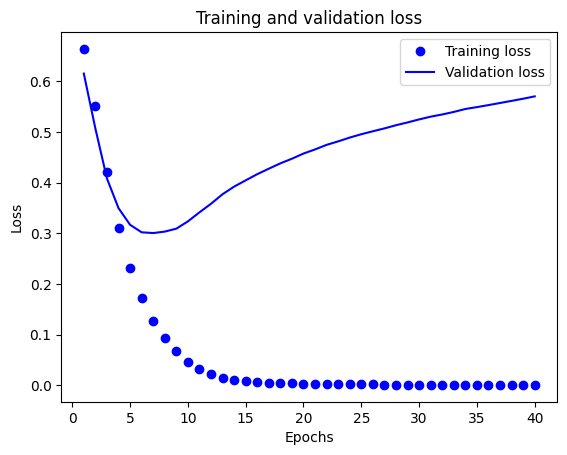

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

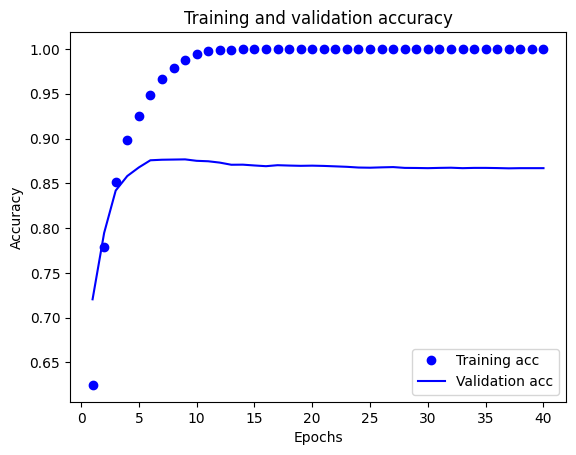

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.